# Week Four - Parameter Estimation and Fitting Data

<hr style="border:2px solid gray">
<a id='outline'></a>

# Outline

1. [Introduction to Estimation](#section1)
1. [Fitting](#section2)
1. [Parameter Uncertainty Intervals](#section3)
1. [Fitting Using iminuit](#section4)
1. [Exercises](#exercises)

<hr style="border:2px solid gray">
<a name="section1">

# Section One: Introduction to Estimation [^](#outline)

In physics, it is common that we have a theory for a process which contains some parameters whose values are not known. For example Newton's law of gravity has one unknown constant $G$ while the standard model of particle physics has over twenty. So we do some experiment to try to determine if the theory is a good fit (see goodness of fit last week) and then find the best value for the parameters in our theory. For example, in particle physics there are many experiments we can do to see if the standard model with our current best parameter values (a null model) is consistent with data and at the same time theorists have many suggestion for new physics which leads to a new model of particle physics (an alternative hypothesis) and we need to know the parameters in the alternative model. The data taken in experiments such as those at the LHC is used to look at which theory is the best fit (last week) and to make estimates of these parameters (this week).

Determining the values of these model parameters is referred to as **estimation** and is one of the most important applications of statistics in science. Last week, we saw that hypothesis tests aim to answer the question "Is the particular parameter value consistent with the data?". This week, we instead want to answer "What value of the parameter is *most* consistent with the data?".

Such an estimate is called the **best estimate** of the parameter, and as you would expect typically corresponds to regions where the PDF is largest. 

There are many ways we can estimate a parameter value from a set of data we have measured. The objective is to find some function $M$ of the measurements $X_i$ that gives an estimate of the value of some parameter $\theta$, 

\begin{equation*}
\hat{\theta} = M(X_1, \cdots, X_N)
\end{equation*}

Specific methods of estimation specify the function $M$. Different parameter estimation methods are used in different situations and we will cover two major methods in this workbook.

Notation: that we denote the estimate of a parameter with a "hat" as $\hat{\theta}$ to distinguish it from the true but unknown value of that parameter $\theta$. This is because our estimate $\hat{\theta}$ is a function of random variables so our estimate $\hat{\theta}$ is itself a random variable. 



#### Example

Let us consider a linear relationship where $y=X$ for a given set of values for the independent variable $𝑋$ while we add some Gaussian noise to the values of the dependent variable $y$ to simulate experimental noise. We want to fit this data with a straight line, with equation $y = mX$.  Note we will focus on just one parameter for now. We can try several different values of the parameter $m$ by hand and just by eye judge which line fits the data best. We will generate this data using `numpy.random`:

In [2]:
import numpy as np
np.random.seed(1) # Set the random seed for consistency

X = np.linspace(0,10,20) # For simplicity these X values are not chosen randomly (they could have been) but are equally spaced 

y = X + np.random.default_rng().normal(loc = 0, scale = 0.5, size = len(X)) # Add Gaussian noise, mean 0, std.dev 0.5

Let us consider 3 possible values of $m$: 0.8, 1, and 1.2. The three straight lines with these parameter values are shown against the data in the plot below. Note each measurement is a single data point and we have no information on the uncertainty in the measurement from the data so we can not add error bars to points.

Text(0.5, 1.0, 'Best fit for linear data')

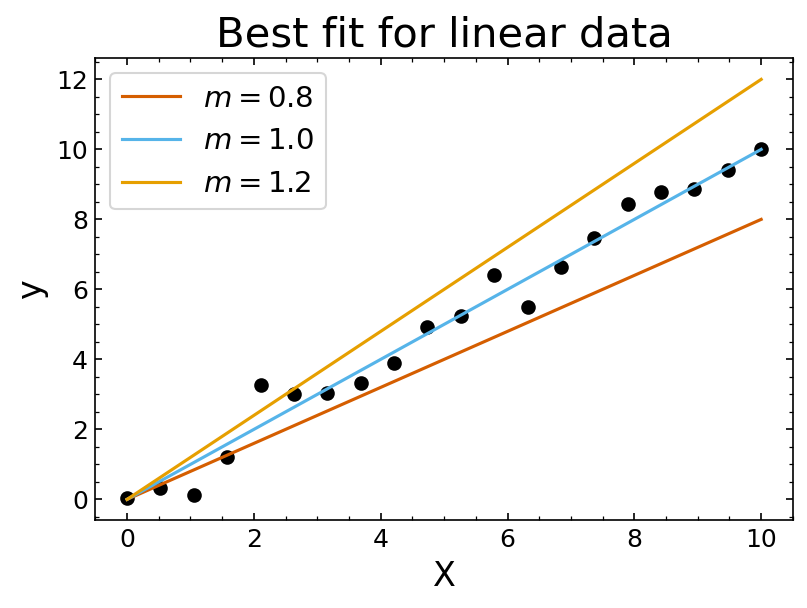

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

gradients = [0.8,1,1.2] # Define gradient parameters
colors = ['#D55E00','#56B4E9','#E69F00'] # Define colours 
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(X,y,color='black')
for m,c in zip(gradients,colors):
    ax.plot(X,m*X,c=c,label='$m = {:.1f}$'.format(m))

ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
ax.legend(loc='upper left',fontsize = 14)
ax.tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_title('Best fit for linear data',fontsize = 20)


Is it clear that $m = 1$ (the true underlying form) is the best choice of parameter? Try another seed to see if your answer changes.

Maybe it is clear on your computer, maybe not. For me, with random seed zero, I found slightly more circles intersected the $m=0.8$ line than the $m=1.0$ line while few were on the $m=1.2$ line. Most of the issue was at low $X$ values (EFS why?). Repeating with seed=1 the $m=1.0$ line was the best but still very unclear at low $X$.

Of course, in general we can't practically test different parameter values visually to fit your data, and in science what we really want to extract is the specific value of the fit that best describes the data. This is where we need other tools to estimate our parameters.

#### Good estimates

Many methods of estimation exist, where some are better than others. Good estimates are:

1. Consistent: in the limit of large N, $\hat{\theta} \to \theta$ i.e. the estimate converges to the true value
<br>

1. Unbiased: $E(\hat{\theta})  = \theta$ i.e. the expectation of the estimate equals the true value
<br>

1. Efficient: $V(\hat{\theta})$ is small, i.e. the variance in the estimate is small.

The expectation value $E(\ldots)$ and the variance $V(\ldots)$ shown here come from where we imagine that same identical experiment is done by many different people. The expectation and variance is found by looking at how the results vary from person to person. 

<div style="background-color: #FFF8C6">

The expectation value $E(\ldots)$ and the variance $V(\ldots)$ referred to above are theoretical results in the sense that if we really had repeated the experiment $N$ times, we would combine all the data to get better estimates of the parameters. 

However you could imagine that the experiment is to measure Newton's constant of gravity $G$ which is done by a lab full of $N$ physicists.  Each student $i$ hands in their lab book with their estimate of $G_I$ and does not improve this with the results obtained by other students. The HoL (Head of Lab) could do an analysis which should show the mean of all the student's results was closer to the best current estimate of $G$. More interestingly, by using all the student results, the HoL could estimate the standard deviation $\hat{\sigma}$ for the experiments (again, not the true value but an estimate).  Now the HoL can look to see if there is any student whose result is so far off it can not be explained by statistical uncertainty, i.e. something went wrong with that experiment.  

#### Example: finding the mean of data is an estimate

One of the most common methods of estimation that you may not have realised is formally an estimate: finding the mean of a set of measurements.

\begin{equation*}
\hat{\mu} = \frac{1}{N}\sum_{i = 1}^N X_i
\end{equation*}

In this example the function $M$ is the sum of the measurements, divided by the number of measurements made. We have put a hat on the symbol "mu" used here for the mean. That is because if the $X_i$ are random variables then their sum has some probability distribution which has a precise mean, denoted $\mu$ without a hat. The mean of the data is being used to estimate the true mean $\mu$ of the underlying distribution.

The method of estimating the mean that we have shown above is consistent, unbiased and efficient, its is a good estimator. However, it is obviously only applicable for finding the mean, rather than any parameter in general. This workbook will discuss two different methods of more generally estimating parameters of distributions or functions from data; namely, using the chi-squared and maximum likelihood estimators. The former is typically best applied for measurements made of variables with at least approximately Gaussian distributions, whereas the maximum likelihood method can be applied for any probability distribution. 

Both of these methods involve finding parameter values to maximise or minimise some function, and are referred to as **fitting**. 

## Summary

In this section, we have introduced the concept of parameter estimation, including:

* Best estimates of parameters
* Properties of good estimates

In the following section, we will discuss the concept of fitting: optimising some function to find the best possible parameter values for our data.

<hr style="border:2px solid gray">
<a id='section2'></a>

# Section Two: Fitting [^](#outline)


In order to find the best estimates of parameters, one of the most common methods is fitting. To do this, we define some **cost function** of our data and our proposed model (and associated parameters) and we aim to maximise or minimise this function, depending on the specific choice of function. You will see this concept again many times as we discuss machine learning in the rest of this course.

As previously mentioned, we will discuss two different methods with different cost functions; we will start with the most familiar, the chi-squared method.

## The chi-squared estimation method

Recalling last week, we discussed the $\chi^2$ value as a method for determining the goodness of fit for a given model to some experimental data, where we hypothesise the data is distributed with some Gaussian noise about the model prediction and test whether the measurements are consistent with that hypothesis. 

However, we can take this concept one step further, and instead try to optimise the value of $\chi^2$ by choosing different parameter values $\theta$ (for simplicity we assume one parameter for now). We will assume that we want the smallest value of $\chi^2$ (but see warnings about problems when $\chi^2 \ll N_\mathrm{dof}$) so

* Consider some data $\{X_i\}$ that we hypothesise is modelled by some function $f(X_i; \theta)$ with one parameter $\theta$
* By finding a minimum of the $\chi^2$ with respect to $\theta$, we can choose the best estimate $\hat{\theta}$ to describe our data
* To minimise $\chi^2$ with respect to $\theta$, we require:
\begin{align*}
\frac{\partial\chi^2}{\partial\theta} &= 0 \\
\frac{\partial^2 \chi^2}{\partial\theta^2} &\gt 0
\end{align*}

where the first condition requires that we are at a stationary point of the $\chi^2$ function with respect to $\theta$, and the second condition requires that said stationary point is a minimum.

We can apply the same setup for a model with a set of multiple parameters $\{\theta_j\}$, where we require that

\begin{align*}
\frac{\partial\chi^2}{\partial\theta_j} &= 0 \\
\frac{\partial^2\chi^2}{\partial\theta_j^2} &\gt 0
\end{align*}
for all $j$. For $N$ parameters, we must solve these $2N$ equations simultaneously to find our best estimate of each parameter, where the best estimate of parameter $\theta_j$ is denoted as $\hat{\theta_j}$.

We will discuss how we can actually solve this optimisation problem in general later in this workbook.

## The maximum likelihood estimation method

In some experiment, we may know that our results should be distributed according to some probability density function $f(X; \theta)$ but with some unknown parameter $\theta$. In this scenario, we know the functional form of the PDF but not the specific parameter value. We want to do some experiment to determine the value of $\theta$. 

After we make a series of N measurements, we have some data points $X_i$ that are samples from whatever probability distribution underlies the quantity we are measuring. We can therefore define the total probability of our measurements as the product of the probablity of each individual measurement, i.e. as

\begin{equation*}
L(\theta; X_i) = \prod_{i = 1}^Nf(X_i;\theta),
\end{equation*}
where $L(\theta; X_i)$ is the **likelihood function** for our experiment. This is very similar to the likelihood parameter we saw in Bayes theorem, namely it is the probability that we make the measurements we have made for a specific value of the parameter $\theta$. Because our data values $X_i$ are given, they are fixed, the likelihood is only a function of the parameter $\theta$. It is telling us how likely it is that $\theta$ is the correct parameter value given the measurements made $\{X_i\}$. As a result, we will often write the likelihood function as $L(\theta)$ to emphasise this fact. 

Note: the likelihood function is *not* a PDF for $\theta$, and is only proportional to the probability of $\theta$ being the correct value given the measurements $X_i$, so $\int L(\theta; X_i) d\theta \neq 1$ in general.

#### Example

For example, let us consider an experiment where we have a bag of coloured balls. We pull a ball out, note the colour and then return it to the bag. We do this ten times (ten "trials") and the  colour of the balls is r,B,r,r,B,r,r,r,B,r where r indicates a red ball and B is a blue ball. Here $X_i$ is the colour of the ball we pull out on the i-th attempt so $X_1=r$ and $X_9=B$. 
We want to estimate the probability $p$ of pulling out a blue ball on any one attempt, i.e. the fraction of blue balls in the bag. 

The obvious model to use is a binomial model as there are only two outcomes we are interested in: blue ball or not a blue ball. We will call our parameter $p$ here. Our $f(X,p)$ is the probability (not a probability density) that if there are a fraction $p$ blue balls in the bag then we get result $X=B$ with probability $p$ and result $X=\tilde B$ (not B) with probability $(1-p)$. That is

\begin{eqnarray}
 f(X;p) =&  p &\; \text{if} \; X=B
 \\
 & (1-p) &\; \text{if} \; X = \tilde B
\end{eqnarray} 

So in our case the likelihood is given as

\begin{eqnarray}
L(\theta; \boldsymbol{X}) \equiv L(p; (r,B,r,r,B,r,r,r,B,r) ) &=& f(X_1;p)f(X_2;p) \ldots f(X_{10};p) \\
                    &=& (1-p).p.(1-p).(1-p).p.(1-p).(1-p).(1-p).p.(1-p) \\
                    &=& p^3(1-p)^7
\end{eqnarray}

The cell below plots this likelihood, as a function of $p$. 

Integral of L(p) between 0 and 1 = 0.0007575757575757576


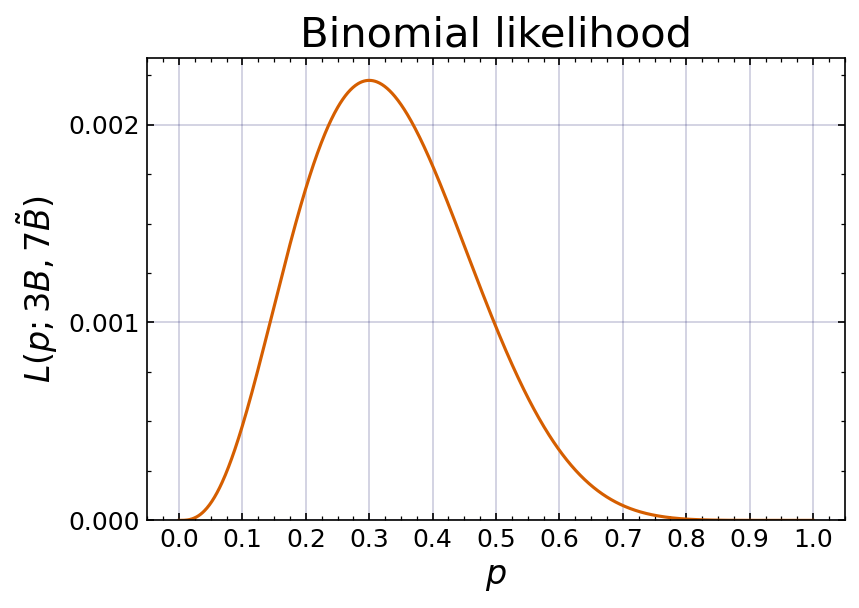

In [4]:
def L(p):
    return p**3*(1 - p)**7

p = np.linspace(0,1,1000)
L_p = L(p)

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.plot(p,L_p,color='#D55E00')
ax.set_xlabel('$p$',fontsize = 16)
ax.set_ylabel(r'$L(p; 3B, 7\tilde B)$',fontsize = 16)
ax.tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_major_locator(MultipleLocator(0.001))
ax.yaxis.set_minor_locator(MultipleLocator(0.00025))
ax.set_ylim(bottom = 0)
ax.set_title('Binomial likelihood',fontsize = 20)
ax.grid(color='xkcd:dark blue',alpha =0.2)

# Lazy check to show this liklihood for p is not normalised, you can do this integral exactly!
import scipy.integrate as integrate
result = integrate.quad(L, 0, 1.0)
print("Integral of L(p) between 0 and 1 = "+str(result[0]))

Our common sense suggests that our estimate for $p$, denoted $\hat{p}$, would equal the frequency of blue balls found in our experiment, that is $\hat{p} = 3/10 = 0.3$. We can now see that our more sophisticated likelihood gives exactly this results, namely that the liklihood function peaks at $0.3$. The value of $p$ that gives the maximum likelihood, which therefore maximises the probability of observing the data we have measured, gives a sensible estimate for $p$. 

In practice, we will take logarithms of likelihood functions to produce the **log-likelihood**, because this is more numerically stable for computing values, particularly for binned measurements with many bins. Because the logarithm is a monotonically increasing function, the maximum of $L(\theta)$ is at the same value of $\theta$ as the maximum of $\ln(L(\theta))$ and so we can use $\ln(L)$ for all calculations. The code cell below plots the log-likelihood for the binomial example.

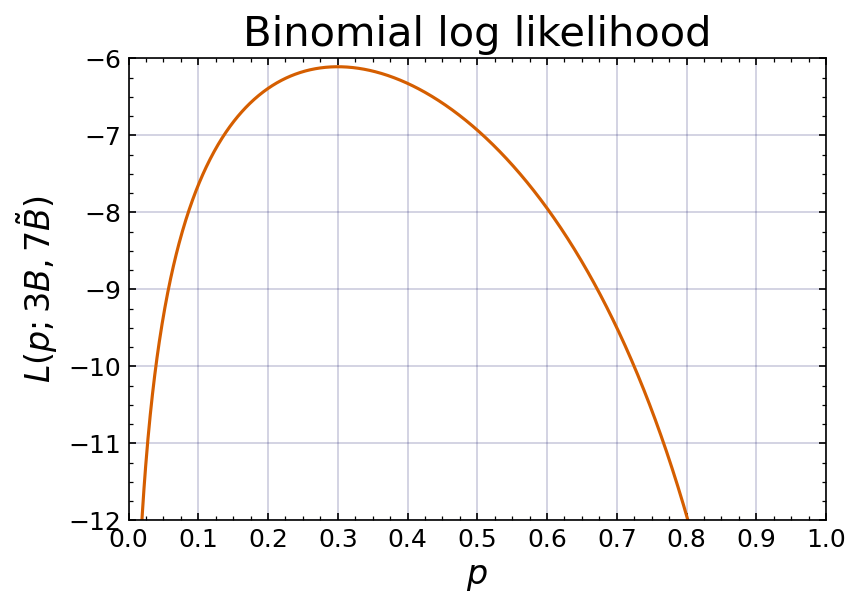

In [5]:
p2 = np.linspace(0.01,0.82,1000) # limit range to avoid log(0.0) 
L_p2 = L(p2)

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.plot(p2,np.log(L_p2),color='#D55E00')
ax.set_xlabel('$p$',fontsize = 16)
ax.set_ylabel(r'$L(p; 3B, 7\tilde B)$',fontsize = 16)
ax.tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlim(0.0,1.0)
ax.set_ylim(-12,-6)
ax.set_title('Binomial log likelihood',fontsize = 20)
ax.grid(color='xkcd:dark blue',alpha =0.2)

<div style="background-color: #FFF8C6">

EFS: What if in our ten trials we found r,B,g,g,B,r,g,r,B,r where "g" represents a green ball pulled from the bag? Would our estimate for the probability of pulling out a blue ball change from $\hat{p} = 3/10 = 0.3$?

What happens if we make more trials of this experiment, and find we see the outcome 30 times out of 100? Again we would expect our estimate $\hat{p}$ to be equal to 0.3 (30/100), but we would expect to be more confident in that measurement. We can see this in the likelihood and log-likelihood functions in the plots below. Both of these peak at $p = 0.3$ as expected but now they are much more sharply peaked at this value. We therefore expect the width of the likelihood function to be correlated with the error on the estimated parameter value. We will discuss this in Section Three. 

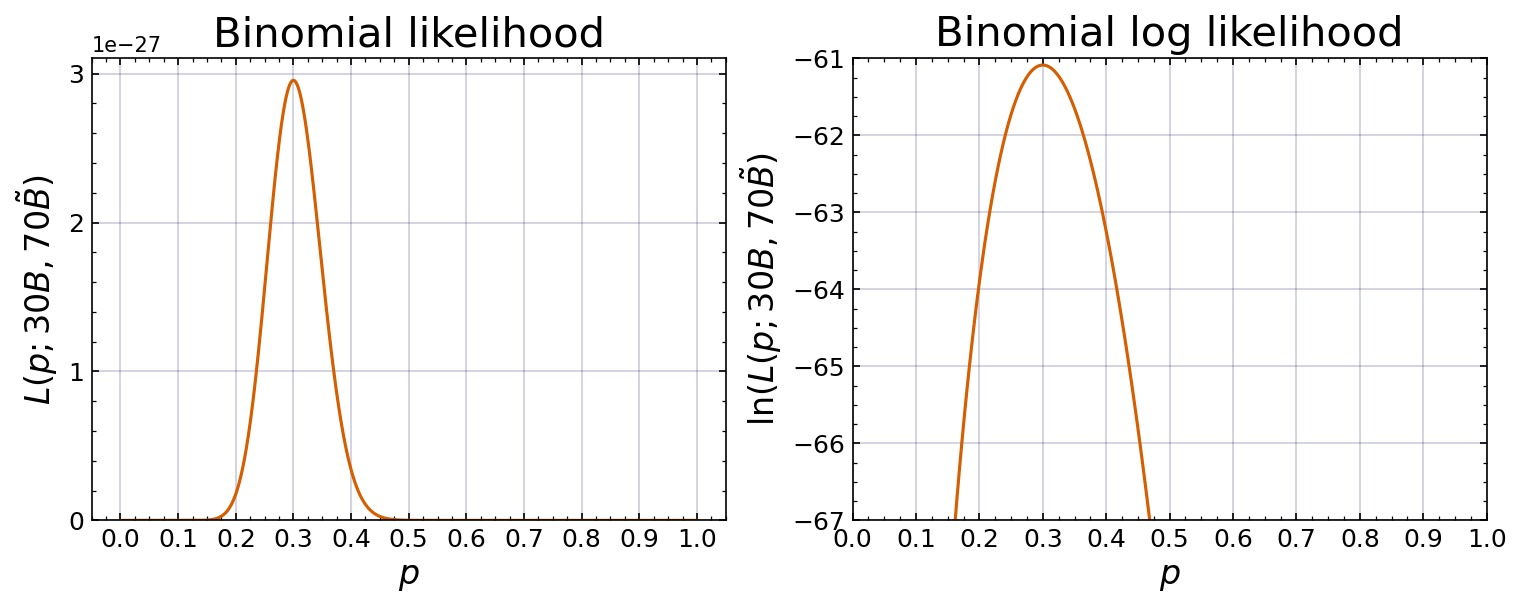

In [6]:
def L100(p):
    return p**30*(1-p)**70

fig, axs = plt.subplots(1,2,figsize = (12,4),dpi = 150)
axs[0].plot(p,L100(p),color='#D55E00')
axs[0].set_xlabel('$p$',fontsize = 16)
axs[0].set_ylabel(r'$L(p; 30B, 70\tilde{B})$',fontsize = 16)
axs[0].tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
axs[0].xaxis.set_major_locator(MultipleLocator(0.1))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.025))
axs[0].yaxis.set_major_locator(MultipleLocator(1e-27))
axs[0].yaxis.set_minor_locator(MultipleLocator(2e-28))
axs[0].set_ylim(bottom = 0)
axs[0].set_title('Binomial likelihood',fontsize = 20)
axs[0].grid(color='xkcd:dark blue',alpha =0.2)

p3 = np.linspace(0.1,0.5,100) # Limit range due to overflows
axs[1].plot(p3,np.log(L100(p3)),color='#D55E00')
axs[1].set_xlabel('$p$',fontsize = 16)
axs[1].set_ylabel(r'$\ln(L(p; 30B, 70 \tilde{B})$',fontsize = 16)
axs[1].tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
axs[1].xaxis.set_major_locator(MultipleLocator(0.1))
axs[1].xaxis.set_minor_locator(MultipleLocator(0.025))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[1].set_xlim(0.0,1.0)
axs[1].set_ylim(-67,-61)
axs[1].set_title('Binomial log likelihood',fontsize = 20)
axs[1].grid(color='xkcd:dark blue',alpha =0.2)

In fact, this idea can be taken as a principle, referred to as the **maximum likelihood principle**: the values of the parameters that maximise the log-likelihood function are the best estimates of those parameters. This is a very general method; we assume our measurement value is at the peak of the PDF, and we adjust the PDF parameters to match our data. 

These estimates are consistent, efficient, and unbiased at least in the limit of large numbers of data points. In general, we take the same approach as for the chi-squared method: we want to maximise the log-likelihood with respect to the parameters $\theta_j$ to find the best estimate of each parameter, by requiring:

\begin{align*}
\frac{\partial\ln(L)}{\partial\theta_j} &= 0 \\
\frac{\partial^2\ln(L)}{\partial\theta_j^2} &\lt 0 
\end{align*}

For the binomial example above (with 3 successes and 10 trials), we find that

\begin{equation*}
\ln(L) = \ln(120p^3(1-p)^7) = \ln(120) + 3\ln(p) + 7\ln(1-p)
\end{equation*}

and then that the derivative is given as

\begin{equation*}
\frac{\partial\ln(L)}{\partial p} = \frac{3}{p} - \frac{7}{1-p}
\end{equation*}

We find the estimate $\hat{p}$ by setting this equal to 0, giving:

\begin{equation*}
\frac{3}{\hat{p}} = \frac{7}{1-\hat{p}} \qquad \text{so} \qquad 3 - 3\hat{p} = 7\hat{p} \qquad \text{so} \qquad \hat{p} = \frac{3}{10}
\end{equation*}
exactly as we would expect. 

In general we cannot compute parameter estimates analytically, much like with the chi-squared method. 



### Gaussian approximation

It is useful to consider parameter estimation for the Gaussian case explicitly for reasons that will become clear. We can write the PDF for a single measurement of a random variable $X$ distributed according to some normal distribution $N(\mu, \sigma)$ as

\begin{equation*}
f(X; \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-(x-\mu)^2/2\sigma^2} \qquad \text{so} \qquad \ln(f(X; \mu, \sigma)) = -\ln\left(\sigma\sqrt{2\pi}\right) - \frac{(x - \mu)^2}{2\sigma^2}
\end{equation*}

If we know $\sigma$, we can make an estimate of $\mu$ from one measurement $X_1$. The log-likelihood is given as

\begin{equation*}
\ln(L(\mu)) = -\ln\left(\sigma\sqrt{2\pi}\right) - \frac{(X_i - \mu)^2}{2\sigma^2}
\end{equation*}

which peaks at $\hat{\mu} = X_1$ as you would expect. 

The reason this is such an important case to consider is due to how all functions behave near a maximum; if we take the Taylor expansion of any function near a maximum (where the first derivative is zero), then the function will approximate to a constant term plus a negative quadratic term, much like our Gaussian log-likelihood. The plot below compares the true log-likelihood and the Gaussian approximation for the binomial example before, both binomial examples given above. As a result, we say that the likelihood function for any PDF is approximately Gaussian near the peak. This will be key when we discuss how we can estimate the error on our estimated parameters. 

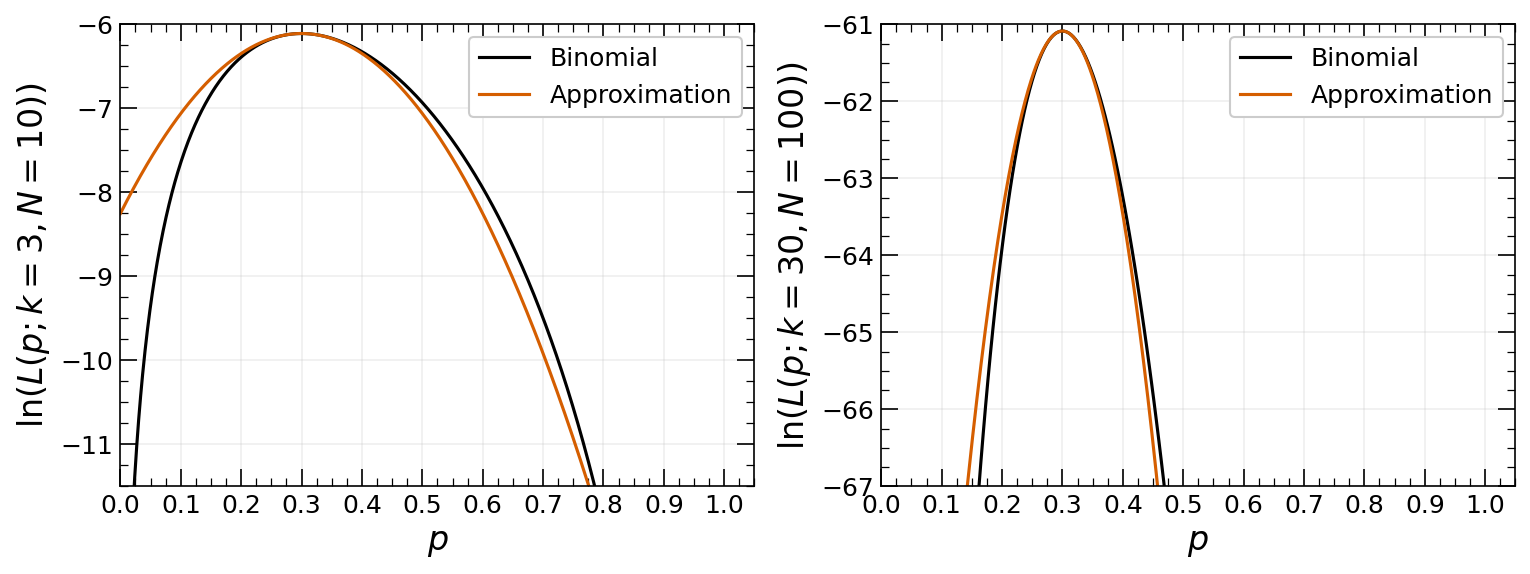

In [7]:
fig, axs = plt.subplots(1,2,figsize = (12,4),dpi = 150)

# Use p2 list to avoid log(0.0)
axs[0].plot(p2,np.log(p2**3*(1-p2)**7),color='black',label='Binomial')
axs[0].plot(p,np.log(0.3**3*0.7**7) + 0.5*(-3/0.3**2 - 7/0.7**2)*(p - 0.3)**2,color='#D55E00',label='Approximation')
axs[0].set_ylim(-11.5,-6)
axs[0].set_xlim(left=0)
axs[0].set_xlabel('$p$',fontsize = 16)
axs[0].set_ylabel('$\ln(L(p; k = 3, N = 10))$',fontsize = 16)
axs[0].tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
axs[0].tick_params(which='major',size = 8)
axs[0].tick_params(which='minor',size = 4)
axs[0].xaxis.set_major_locator(MultipleLocator(0.1))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.025))
axs[0].yaxis.set_major_locator(MultipleLocator(1))
axs[0].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[0].legend(loc='upper right',fontsize = 12,framealpha = 1)
axs[0].grid('xkcd:dark blue',alpha = 0.2)

# Use p3 list to avoid log(0.0)
axs[1].plot(p3,np.log(p3**30*(1-p3)**70),color='black',label='Binomial')
axs[1].plot(p,np.log(0.3**30*0.7**70) + 0.5*(-30/0.3**2 - 70/0.7**2)*(p - 0.3)**2,color='#D55E00',label='Approximation')
axs[1].set_ylim(-67,-61)
axs[1].set_xlim(left=0)
axs[1].set_xlabel('$p$',fontsize = 16)
axs[1].set_ylabel('$\ln(L(p; k = 30, N = 100))$',fontsize = 16)
axs[1].tick_params(which='both',labelsize = 12,top=True,right=True,direction='in')
axs[1].tick_params(which='major',size = 8)
axs[1].tick_params(which='minor',size = 4)
axs[1].xaxis.set_major_locator(MultipleLocator(0.1))
axs[1].xaxis.set_minor_locator(MultipleLocator(0.025))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[1].legend(loc='upper right',fontsize = 12,framealpha = 1)
axs[1].grid('xkcd:dark blue',alpha = 0.2)


From these plots, it can be seen that the approximation is most accurate near the peak, but the range for which it is accurate increases if we increase the number of trials (as we expect for a Gaussian approximation). 

For a set of measurements $X_i$ of Gaussian distributed random variables, each with different (unknown) mean $\mu_i$ and (known) width $\sigma_i$, we can show that maximising the log-likelihood with respect to the means $\mu_i$ is equivalent to minimising the chi-squared with respect to the same parameters. In fact, we find that 

\begin{equation*}
\chi^2 = 2C - 2\ln(L)
\end{equation*}
for some constant $C$ (which is constant if the widths $\sigma_i$ are known). As a result, it is common to find a minimum of $-2\ln(L)$ rather than trying to maximise the log-likelihood, as this is directly comparable to the chi-squared in the Gaussian case. 

## Numerical optimisation of cost functions

So far we have discussed two different cost functions that we can optimise in order to estimate our parameters: the chi-squared and the log-likelihood. However, we cannot always analytically solve to find our estimates and instead must apply numerical methods. While we won't cover this in detail here, it is important you are aware of what kinds of approaches might be used.

One of the most common algorithm used for these optimisation problems is **gradient descent**. Specifically, we use gradient descent for minimisation problems; either for minimising the $\chi^2$, or minimising the negative log-likelihood (equivalent to maximising the log-likelihood). To do this, we make updates to the parameter estimate by changing it by some small value in the direction of the negative gradient, i.e. we step towards the point where gradient tends to 0. This is illustrated in the figure below.

<img src='Week4_plots/gradient_descent_example.png' align='center' width=600>

*Example of how the parameter value $\theta$ updates in an application of gradient descent. In this scenario, the cost function is given as $X^2$. With each step in the direction of the negative gradient, we move towards the minimum of the cost function*




The amount we change our parameter $\theta$ by in each step is proportional to the gradient and to a parameter called the **learning rate**, which we label as $\alpha$. In fact, the learning rate belongs to a type of parameter called **hyperparameters**, which can be defined as *parameters of the learning algorithms, and not of the model*. We will see this concept more when we talk about machine learning in the rest of this course.

<div style="background-color:#FFCCCB">



The main steps of this algorithm are as follows:

1. Define an initial parameter guess $\theta_{\text{init}}$ and set our parameter estimate $\hat{\theta}$ equal to it
1. Calculate (numerically) the gradient of the cost function $q$ evalauted at the initial guess, $\frac{\partial q}{\partial \hat{\theta}}$
1. Update the value of $\hat{\theta}$ according to
\begin{equation*}
\hat{\theta} = \hat{\theta} - \alpha \frac{\partial q}{\partial\hat{\theta}}
\end{equation*}
where $\alpha$ is a parameter known as the **learning rate**. 
1. Repeat steps 2 and 3 until the value of the cost function is below some satisfactory value or satisfies some convergence condition



Because the learning rate is a hyperparameter of the algorithm, it must be chosen carefully to give good performance. If the learning rate is too low, we can take a long time to find a minimum as we need to make many steps. It is also possible to get caught in a local minimum of the cost function, rather than finding the global minimum. If the learning rate is too high, we may "skip" over the minimum and instead oscillate around the minimum or diverge away from it. A good choice of learning rate will result in fast convergence to a global minimum. The figure below shows these three scenarios.

<img src='Week4_plots/lr_scenarios.png' align='center' width = 1400>

*Different learning rate scenarios. For low learning rates, too many updates are required to reach the minimum, while a large learning rate causes drastic updates leading to divergent behaviour.*

You will not need to code gradient descent yourself; it is very well implemented in many software packages, including the `iminuit` package we will use for fitting. You will see this library in more detail later in this workbook. The same method can be applied to models with multiple parameters, we must simultaneously optimise the cost function with respect to all of the parameters. You will also see gradient descent again in Week 9 when we discuss neural networks.



## Summary

In this section you have seen how we can make best estimates of parameters from data we have measured, including:

* Chi-squared minimisation
* The maximum likelihood principle
* Gradient descent to minimise cost functions

The following section will discuss how we can determine the error on parameters we have estimated. 

<hr style="border:2px solid gray">
<a id='section3'></a>

# Section Three: Parameter Uncertainty Intervals [^](#outline)

When we make measurements of anything, we need to know the uncertainty on the measurement, because this tells us how much we can trust the value we have measured. Much like we consider uncertainty on the values we measure, we need to find uncertainties for parameters that we estimate. In this section, we will discuss how we can find parameter uncertainties from our fitting methods and then how this links back to the confidence interval we discussed for hypothesis testing last week.

We will first discuss our two main estimation methods in turn.

## Chi-squared parameter uncertainties

As we have previously defined, the chi-squared is a function of the parameters of our fit for measured data $\{X_i,y_i\}$, and can be written as

\begin{equation*}
\chi^2(\theta; y_i) = \sum_{i = 1}^N\left[\frac{y_i - f(X_i; \theta)}{\sigma_i}\right]^2
\end{equation*}
where $f(X_i; \theta)$ is our model prediction at the point $X_i$ and $\sigma_i$ is the uncertainty on the measurement $y_i$.

Consider taking a Taylor expansion around the minimum of the chi-squared which occurs at $\theta = \hat{\theta}$, assuming just one parameter for clarity. At a minimum, the linear term disappears and we are left with

\begin{equation*}
\chi^2(\theta) \approx \chi^2(\hat{\theta}) + \left.\frac{d^2\chi^2}{d\theta^2}\right|_{\theta = \hat{\theta}} \frac{(\theta - \hat{\theta})^2}{2} + \cdots
\end{equation*}

We know the second derivative must be positive as the best-fit chi-squared is a minimum. We will therefore define

\begin{equation*}
\frac{1}{\Sigma^2} = \frac{1}{2}\left.\frac{d^2\chi^2}{d\theta^2}\right|_{\theta = \hat{\theta}}
\end{equation*}

which allows us to write

\begin{equation*}
\chi^2(\theta) \approx \chi^2(\hat{\theta}) + \frac{(\theta - \hat{\theta})^2}{\Sigma^2}
\end{equation*}

We can interpret the second term of this as a residual divided by an uncertainty, like we saw when we talked about the chi-squared goodness-of-fit test. We therefore can identify our quantity $\Sigma$ as the uncertainty on the best estimate $\hat{\theta}$. 


<div style="background-color:#FFCCCB">

If we had a vector of multiple parameters $\boldsymbol{\theta}$, then the uncertainty $\Sigma$ is actually a matrix $\boldsymbol{\Sigma}$ and is referred to as the **error matrix**. The diagonal element $\Sigma_{ii}$ is are the uncertainty on the parameter $\theta_i$, while the off-diagonal element $\Sigma_{ij}$ is the covariance of the parameters $\theta_i$ and $\theta_j$. For uncorrelated parameters $\theta_i$ and $\theta_j$, the covariance $\Sigma_{ij} = 0$. 

We define the elements of the weight matrix $\mathbf{W} = \boldsymbol{\Sigma}^{-1}$ as
$$
W_{ij} = \frac{1}{2}\left.\frac{\partial^2\chi^2}{\partial\theta_i\partial\theta_j}\right|_{\theta = \hat{\theta}}
$$
which is half of what is called a [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) of the function $\chi^2$ evaluated at $\hat{\theta}$.
    
To find the covariance matrix, we must invert the weight matrix.

If the second derivative of the chi-squared is easy to calculate, the uncertainty on the best estimate can be found through this method. However, because the chi-squared method can be used for arbitrarily complex functions $f(X_i; \theta)$, we cannot always calculate the second derivative practically. 

Instead, we adopt a perturbation approach: what happens if we perturb the value of the parameter $\theta$ from the value that gives the minimum chi-squared? Let us specifically consider shifting the parameter from $\hat{\theta}$ to $\hat{\theta} \pm \Sigma$. From our Taylor expansion, we can see this becomes

\begin{align*}
\chi^2(\hat{\theta} \pm \Sigma) &\approx \chi^2(\hat{\theta}) + \frac{(\hat{\theta} \pm \Sigma - \hat{\theta})^2}{\sigma^2} \\
&\approx \chi^2(\hat{\theta}) + \frac{\Sigma^2}{\Sigma^2} \\
&\approx \chi^2(\hat{\theta}) + 1
\end{align*}

i.e. the value of the chi-squared changes by 1 if we change the parameter from the best estimate by $\pm \Sigma$. As a result, if we numerically evaluate the chi-squared for different values of theta, the range for which the chi-squared changes by up to 1 gives the uncertainty on $\hat{\theta}$. An example for such an approach can be seen in the figure below.

<img src='Week4_plots/chi_square_intervals_example.png' align='center' width = 600>

*Determining uncertainty intervals from the chi-squared distribution for a parameter estimate $\hat{\theta}$. From this we determine that the best estimate is $\hat{\theta} = 2 \pm 0.82$.*

## Maximum likelihood parameter uncertainties

For maximum likelihood parameter uncertainties, we adopt a very similar approach to the one we have just outlined for the chi-squared. By taking a Taylor expansion around the maximum of the log-likelihood and knowing that the second derivative must be negative as we are at a maximum, we find that

\begin{equation*}
\ln(L(\theta)) \approx \ln(L(\hat{\theta})) + \left.\frac{d^2\ln(L)}{d\theta^2}\right|_{\theta = \hat{\theta}}\frac{(\theta - \hat{\theta})^2}{2!} + \cdots
\end{equation*}

This time, we identify the constant $\Sigma$ according to

\begin{equation*}
\frac{1}{\Sigma^2} = -\left.\frac{d^2\ln(L)}{d\theta^2}\right|_{\theta = \hat{\theta}}
\end{equation*}

The negative sign means that $\Sigma^2$ is positive and thus that $\Sigma$ is real. We can then write the approximation as

\begin{equation*}
\ln(L(\theta)) \approx \ln(L(\hat{\theta})) - \frac{(\theta - \hat{\theta})^2}{2\Sigma^2} + \cdots
\end{equation*}

By ignoring higher order terms and taking the exponential of both sides, we find that

\begin{equation*}
L(\theta) \approx L(\hat{\theta})e^{-(\theta - \hat{\theta})^2/2\Sigma^2}
\end{equation*}

i.e. a Gaussian function in $\theta$, with mean $\hat{\theta}$ and width $\Sigma$. We therefore identify $\Sigma$ as the uncertainty on the parameter $\theta$.


<div style="background-color:#FFCCCB">

This holds for the single parameter case; if we have more than one parameter, then we must again invert the weight matrix $\mathbf{W}$ like for the chi-squared case, where the elements $W_{ij}$ are defined as 

\begin{equation*}
W_{ij} = -\left.\frac{\partial^2ln(L)}{\partial\theta_i\partial\theta_j}\right|_{\theta = \hat{\theta}}
\end{equation*}

and the error matrix $\boldsymbol{\Sigma}$ is the inverse of the weight matrix.

What if the Gaussian approximation isn't a good approximation to our function, or it is difficult to evaluate the second derivative of the log-likelihood? We will use a similar approach to the chi-squared, namely examining the value of the log likelihood at $\theta = \hat{\theta} \pm \Sigma$ to find a range of log-likelihood values that correspond to our uncertainty.

We will start with the Gaussian case, and then claim (without proof) that this applies for non-Gaussian likelihoods as well (for the large N limit in general but as a good approximation normally).

\begin{align*}
\ln(L(\hat{\theta}\pm\Sigma)) &= \ln(L(\hat{\theta})) - \frac{(\hat{\theta} \pm \Sigma - \hat{\theta})^2}{2\Sigma^2} \\
&= \ln(L(\hat{\theta})) - \frac{\Sigma^2}{2\Sigma^2} \\
&= \ln(L(\hat{\theta})) - \frac{1}{2}
\end{align*}

i.e. the uncertainy is the range that changes the log-likelihood by -1/2, whereas for the chi-squared we look for the range that changes by +1. This range can in general be asymmetric. This is shown for a binomial example with distribution $B(3, 10)$ in the figure below.

<img src='Week4_plots/log_likelihood_intervals_example.png' align='center' width=600>

*Example of calculating estimated parameter uncertainty using log-likelihood estimation for a binomial distribution. In this case, the best estimate $\hat{p} = 0.3^{+0.155}_{-0.13}$.*

We can use the same method in general rather than only for Gaussian likelihoods as a pretty good approximation (which improves as the number of measurements $N$ increases).

## Parameter uncertainties and confidence intervals

We've done a lot of talking about these errors on our estimated parameters and deriving them in analogy with the width of a Gaussian, but what do they actually mean? To understand this, we first need to understand the idea of confidence intervals on random variables.

As a basic example, consider a normally distributed random variable $X$ distributed according to $N(\mu,\sigma)$. If we integrate the PDF between $\mu - \sigma$, and $\mu + \sigma$, we find that the probability of a measurement of $X$ lying in this range is 68.3%. This is referred to as the $1\sigma$ confidence interval: if we make a measurement of $X$, we expect it to lie in this interval 68.3% of the time. 

We can define ranges like these for non-Gaussian distributions, regardless of the parameters of the specific distribution. Despite the fact that the specific value of 68.3% is derived from the integral of a Gaussian, it is very common to use this with any distribution and even refer to it as the $1\sigma$ confidence interval, even if the distribution in question doesn't have $\sigma$ as a parameter. 

However, things can be slightly more complicated for non-Gaussian distributions because they can be asymmetric and as such there is not a unique way to define the confidence interval of a given percentage. For example for the 68.3% interval for a general PDF $f(X)$, we require that

\begin{equation*}
\int_a^b f(X) dX = 0.683
\end{equation*}
where our confidence interval is bounded by $X = a$ and $X = b$. In general this only gives one constraint on two parameters, so they cannot be specified uniquely. A common way to handle this issue is to require that the probability outside of the confidence interval should be equal above and below the range, e.g. for the 68.3% interval we require that

\begin{align*}
\int_{-\infty}^af(X)dX &= 0.159 \\
\int_{b}^\infty f(X)dX &= 0.159
\end{align*}

How does this relate to errors on estimated parameters? Unlike random variables, parameters have an exact value even if it is unkonw to us, which is why we try to estimate them from data that we measure. If we were to make a large number of experiments, we expect that 68.3% (or 95%, or whatever our quoted confidence value is) of the experiments will have the true value within the derived confidence interval. Again we can quote these in terms of numbers of $\sigma$ even if our likelihood or PDF is not Gaussian. 

We can also use one-sided confidence intervals, if e.g. our parameter cannot be negative like a cross section of some rare process, instead we only want to set an upper limit. 


## Summary

In this section we have discussed how we can estimate parameter uncertainties for our two parameter estimation methods, including:

* Estimating uncertainties through direct calculation of cost function derivatives
* Estimating uncertainties through numerical methods
* Connection of parameter uncertainties to confidence intervals

In the next section, we will discuss how we can do accurate and flexible fitting in python using `iminuit`.

<hr style="border:2px solid gray">
<a id='section4'></a>

# Section Four: Fitting Using `iminuit` [^](#outline)

Now we have discussed the theory of how we can estimate parameters from data, we want to put it into practise. `scipy` has a series of functions for fitting data, but in general more advanced packages are preferred. The `minuit` C++ package is commonly used in High Energy Physics, and was developed at CERN. It has a python wrapper called `iminuit` that we will use for fitting in this course. This should be loaded on all physics PCs but if you are using your own machine you may need to [install iminuit](https://iminuit.readthedocs.io/en/stable/install.html).

This section is intended to give an overview of some key `iminuit` syntax that you can work through to make sure you understand how to use the library. The following content is based on the `iminuit` tutorials, available on [their website](https://iminuit.readthedocs.io/en/stable/tutorials.html). 

<div style="background-color: #FFF8C6">
    
You may be familiar with routines such as `curve_fit` in `scipy.optimize`, where we apply `curve_fit` to our data and the function we are fitting to get a result. Here we will see that `iminuit` takes what is called an "object-oriented" approach. That is we create a `Minuit` object, a type of object defined by the `imunuit` package. This `Minuit` object contains everything: data, fitted function, the methods needed to generate the fit, fitted parameter values and their uncertainties.      

## A simple example of a fit using `iminuit`

Like all fitting, we require some data, the function (a "model") we are fitting to the data, and a cost function whose minimum indicates the parameters of the best fit. 

<!-- We can define cost functions manually if we want, but there are many already implemented in `iminuit` that we can use. We provide the data and the model, with some initial parameter guesses, and then the local minimizer (called MIGRAD) will find a local minimum of the model starting from our initial parameter guesses. 

Fundamentally, everything is done through the `Minuit` object, and a cost function. We will begin by importing these: -->



#### Model and Fit Function

Our model used to create the data will also be the same function we use to fit the data.  We will choose a simple line $y = m \, x +c$ with independent variable $x$ and two fixed parameters $m$ and $c$.

In [8]:
# Note this is both the model we use to construct the data and the function we use to fit the data.
def line(x, m, c):
    return x*m + c

#### Artificial data

We will create some artifical data starting from the function we will use to fit the data plus some random noise.  An artifical data set like this is a classic way to test machine learning methods as we know what should be the best answer for our method as we created the data around this idal answer. Can the machine learning method, here curve fitting, find the "correct" answer (the "ground truth")? 

For our data:- 
* We will set the parameters of this model to be $m=1.0$ and $c=2.0$. 
* We will choose a small set of $X$ values.
* For each $X$ value we take our data point to be $ m \, X +c$ plus a Gaussian random number chosens from a normal distribution of mean zero and standard deviation $0.1$.

Note that our data points can be thought of as the mean value for $y$ measured at each $x$ value. Then the standard error in the mean represents the uncertainty in the $y$ values but here this is simply the standard deviation we used when choosing a random number from a Gaussian distribution.

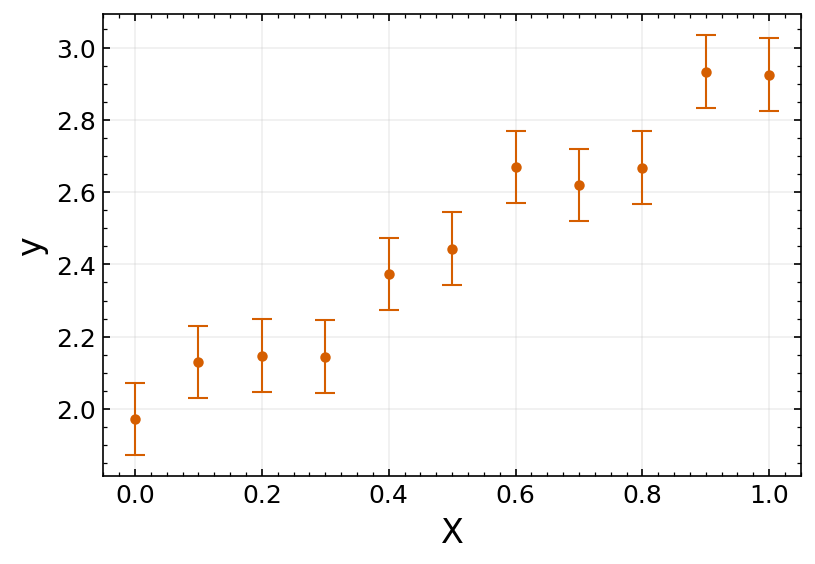

In [9]:
np.random.seed(0) # Set the random seed for consistency. Why not use 0?

# These are the ground truth values hiding in our data
m_value=1.0
c_value=2.0

n_points = 11 # 11 data points
data_x = np.linspace(0,1,n_points) # evenly spaced from 0.0 to 1.0 inclusive 
data_yerr = 0.1 # the standard deviation of the noise
data_y = line(data_x, m_value, c_value) + np.random.default_rng().normal(loc = 0, scale = data_yerr, size = n_points)

# Plot to show the data
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(data_x, data_y, yerr = data_yerr,
            color='#D55E00',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
# ax.xaxis.set_major_locator()
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

#### Cost function

The simplest way to construct a cost function is to ue one of the many provided by `iminuit` as it has all the comon choises. Here we can use the `LeastSquares` class to generate an object which encodes the chi-squared cost function, has the data we are using and the function we want to fit, all in one object. So we need to pass the $X$ values, $y$ values, uncertainty on the $y$ values, and the function we are trying to fit.

In [10]:
# Note: this is equivalent to our chi-squared cost function
from iminuit.cost import LeastSquares 

least_squares_obj = LeastSquares(data_x, data_y, data_yerr, line)

Note how this cost function object we defined knows what the parameters are. This cost function object looks at the function `line` given to it and assumes the second and subsequent arguments are the paramaters, while it assumes the first parameter of `line` is a vector of independent variable values $X$.  

#### Minuit object

Now at last we combine data, fitted function and an initial value for the fitting parameters (needed to start the fitting method) into a single `Minuit` object - we  "instantiate" a `Minuit` object. Everything we need is then in this object. 

Note that choosing initial parameter values can have a big effect on the success of your algorithm in more complicated cases. If our cost function has several minima, the minimium reached after running the optimisation depends on the starting point. We might not even find the global minimum i.e. the best possible fit. Even if the cost function only has one minimum, starting parameter values in the proximity of the minimum will improve the speed of convergence. 

However, for this simple case the initial values will have little effect. 

In [11]:
# If you get an error then maybe iminuit is not installed on your machine.
from iminuit import Minuit 

# Starting parameter values often important but not in this simple case
mobj = Minuit(least_squares_obj, m = 5.0, c = 5.0)

print(mobj.init_params) # shows initial parameter values

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   5.00    │   0.05    │            │            │         │         │       │
│ 1 │ c    │   5.00    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


We can pass the parameters by the name *exactly as used in the fit function*, here our `line` function. These parameter names found by the `Minuit` object through "introspection".

We can also pass the parameters by positional arguments. Looking at our fit function `line` which is the `LeastSquares`, we see the first argument is $m$ and the second is $c$ so another way to define an equivalent Minuit object is

In [12]:
# This does exactly the same job as mobj but isn't as clear to read.
mobj1 = Minuit(least_squares_obj, [5.0, 5.0]) 

print(mobj1.init_params) # shows initial parameter values

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   5.00    │   0.05    │            │            │         │         │       │
│ 1 │ c    │   5.00    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


If we forget a parameter, or we write the wrong name for a parameter, `iminuit` will raise an error. The next two cells will show examples of such errors.

In [13]:
# error, our least_squares_obj uses the line function 
#        which takes two parameters

# UNCOMMENT THIS NEXT LINE TO SEE ERROR
# mobj2 = Minuit(least_squares_obj) 

In [14]:
# error as no h parameter in the line function 
#       inside the least_squares_obj

# UNCOMMENT THIS NEXT LINE TO SEE ERROR
#mobj3 = Minuit(least_squares, h = 10, c = 5) 

### The fit

After instantiating our `Minuit` object, the `mobj` in the previous cell, we will use two different methods: 
* `migrad` (the name of a particular minimisation method) to find the local minimum of the cost function.
There are a few other pre-defined minimizers, but we will just use the MIGRAD algorithm. 
* `hesse` (named after the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix)) to compute the uncertainty on our parameter. 


In a Jupyter notebook, we get a nice rendering of the results of the fitting. 

In [15]:
# Do the fitting

# minimise the least_squares cost function, i.e. find the best fit
mobj.migrad() 

mobj.hesse() # calculate parameter uncertainties

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.741 (chi2/ndof = 0.5)    │              Nfcn = 44               │
│ EDM = 2.47e-23 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   0.98    │   0.10    │            │            │         │         │       │
│ 1 │ c    │   1.97    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        m        c │
├───┼───────────────────┤
│ m │  0.00909 -0.00455 │
│ c │ -0.00455  0.00318 │
└───┴───────────────────┘

<div style="background-color: #C2D5BD"> 

OPTIONAL EFS: You might notice the reduced chi-square is quoted in the output as $\chi^2/\mathrm{ndof}$. What are the degrees of freedom $\mathrm{ndof}$ in this case? As a bonus, can you find out how to get this from the iminuit object, our `mobj`?
    
<!-- 
print("The number of degrees of freedom should be {0:d} and we find {1:d}".format(n_points-2,mobj.ndof)) 
-->    

<!-- The number of degrees of freedom should be number of points minus two as we have two parameters whose values are fixed by the fitting. -->

Hurray! You should see the line is a good fit, not too perfect, not too bad.  The $m$ and $c$ values found are close to, within error, the values we used to create the data (the ground truth values). 

#### Inspecting current parameter values

The `Minuit` object contains the current parameter values, errors, and some other information about each parameter. We can display the current values using `Minuit.params`:

In [16]:
display(mobj.params)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,0.98,0.10,,,,,
1,c,1.97,0.06,,,,,


If we just run `Minuit.params`, it returns a container of `Param` objects which are data structures with various attributes we can query. We can use the `repr` function to get a detailed representation of a given parameter:

In [17]:
for param in mobj.params:
    print(repr(param))

Param(number=0, name='m', value=0.9806860725119996, error=0.09534628150950669, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)
Param(number=1, name='c', value=1.9667285782454038, error=0.05640761890396567, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)


If we want properties of an individual parameter we can access them as follows

In [18]:
for param in mobj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))

m = 0.98 +/- 0.10
c = 1.97 +/- 0.06


In [19]:
print('{} = {:.2f} +/- {:.2f}'.format(mobj.params[0].name, mobj.params[0].value, mobj.params[0].error))


m = 0.98 +/- 0.10


The initial parameter guesses can still be viewed using `Minuit.init_params`.

In [20]:
for param in mobj.init_params:
    print(repr(param))

Param(number=0, name='m', value=5.0, error=0.05, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)
Param(number=1, name='c', value=5.0, error=0.05, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)


#### Visualise the fit

And that's all you need to do for a simple fit using `iminuit`. You should always visualise the fit. This isn't precise statistics but you need to use your common sense and just look to make sure your fitting is working. the automatic version above will do fine for development but here is a fancier version needed for presentation.

<!-- Really, we should look at the fits that are within the errors.  One way to do this is with error bands, Since this is something we often want to do, it is of course it is easy to do in iminuit. See [How to draw error bands](https://iminuit.readthedocs.io/en/stable/notebooks/error_bands.html). -->

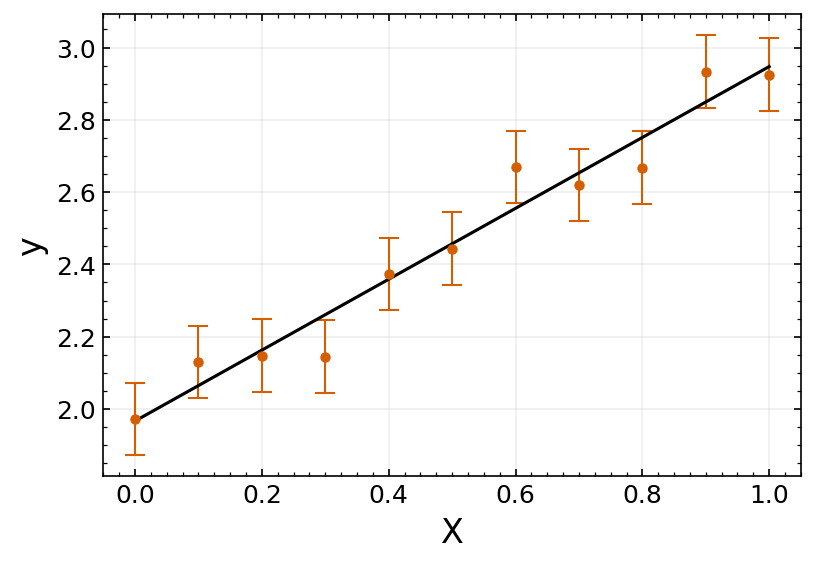

In [21]:
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(data_x, data_y, yerr = data_yerr,
            color='#D55E00',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
ax.plot(np.linspace(0,1,100),line(np.linspace(0,1,100),*mobj.values),color='black')

ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
# ax.xaxis.set_major_locator()
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

Now we have seen how we can do a simple fit, we will talk about each part in more detail.

### Using `iminuit` with an arbitrary number of parameters

We can also use iminuit with functions that accept an arbitrary number of parameters which are defined through data structures such as numpy arrays e.g. $n$-th order polynomials. This has pros and cons.

**Pros**

* Easy to change number of fitted parameters
* Sometimes simpler function body that’s easier to read
* Technically this is more efficient, but this is hardly going to be noticable

**Cons**

* `iminuit` cannot (automatically) figure out names for each parameter
* user (you) might get confused over the name of the parameter linked to each entry in the array of parameter values

In [22]:
""" Functions used by iminuit's LeastSquares take the argument x first 
    (could be an array of x_0, x_1, ... if in more than one dimension) 
    followed by an array of parameter values: 
    par[0] is the first parameter value, par[1] is the second etc. 

    And then notice that numpy's polyval, 
    https://numpy.org/doc/stable/reference/generated/numpy.polyval.html
    which gives us a polynomial in x, puts the arguments the other way round!
    That is polyval wants parameter array first, x array second.
    N.B. The polynomial with N=len(par) has parameter of highest power of x from the first par[0] entry:-
    par[0]*x**(N-1) + par[1]*x**(N-2) + ... + par[N-2]*x + par[N-1]
"""
def line_np(x, par):
    return np.polyval(par, x)  # for len(par) == 2, this is a line

least_squares_np = LeastSquares(data_x, data_y, data_yerr, line_np)

Calling `line_np` with more or fewer arguments is easy. For $N$ arguments, a polynomial of order $(N-1)$ is used to predict the behavior of the data.

The built-in cost functions of `iminuit`, such as the `LeastSquares` used here, support models like our `line_np` with an unspecified number of arguments. However,  for this to work properly, we need to pass the starting values in the form of a single sequence of numbers when constructing the `Minuit` object. That way `iminuit` can work out how many parameters it is fitting. 

For example:-

In [23]:
display(Minuit(least_squares_np, (5.5, 6.0)))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.50,0.06,,,,,
1,x1,6.00,0.06,,,,,


Here we have used a tuple `(5.5,6.0)` for initialisation of the parameters, but any sequence (including lists and numpy arrays) would work. `iminuit` uses the length of the sequence to detect how many parameters the model has, so two here. By default, the *parameters* are named automatically $x_0$ to $x_N$ - yes confusing as these are parameter names and nothing to do with the "x" values of our data. 

We can override this naming convention with the keyword argument `name`, passing a sequence of parameter names. Of course, this sequence must be of the same length as the sequence of starting points.

In [24]:
# The parameter we call "a" starts with value 5.5, etc
display (Minuit(least_squares_np, (5.5, 6.0), name=("a", "b"))) 

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.50,0.06,,,,,
1,b,6.00,0.06,,,,,


In [25]:
# As a quick check lets use the straight line version of the polynomial fit
m_line_obj_np = Minuit(least_squares_np, [5.5, 6.0])
display(m_line_obj_np)

""" These lines fail at line 1878 in the visualize method in iminuit\cost.py 

m_line_obj_np.migrad() 
m_line_obj_np.hesse() # calculate parameter uncertainties
display(m_line_obj_np)

As this looks to be routine for Jupyter notebook visualisation, 
supressing the graphical output foes work suggesting 
the main minimisation effort is working.

BUG?

"""

# minimise the least_squares cost function, i.e. find the best fit
rrr= m_line_obj_np.migrad() 

hhh = m_line_obj_np.hesse() # calculate parameter uncertainties

for param in mobj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))


,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.50,0.06,,,,,
1,x1,6.00,0.06,,,,,


m = 0.98 +/- 0.10
c = 1.97 +/- 0.06


Since our `least_squares_np` works for parameter arrays of any length, we can now define a different `Minuit` object which will fit a cubic polynomial by specifying four initial values:

In [26]:
m_cubic_obj = Minuit(least_squares_np, (5.5, 4.1, 6.9, 0.4))
display(m_cubic_obj)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.50,0.06,,,,,
1,x1,4.10,0.04,,,,,
2,x2,6.90,0.07,,,,,
3,x3,0.400,0.004,,,,,


We can try different orders of polynomial for fitting our data in this way, just by providing different numbers of starting parameters. Of course, getting the wrong order of polynomial for our data can lead to under or over fitting. 

<div style="background-color:#C2F5DD">
    
### Exercise 1

Fit the data set in the following code cell with different orders of polynomial. Describe qualitatively how the fit changes, and how well the fit describes the data as you increase the order of the polynomial. When does the fit show signs of overfitting? Remember the following points:

* Define your cost function
* Define your Minuit object
* Run the optimisation
* Plot the data and your fit

Use the `line_np` function we have previously defined as your model. You can change the order of polynomial by passing more parameters as `pars` to this function. For instance if you call `line_np(X, (5, 5))` you will be testing a linear model, but if you call `line_np(X, (5, 5, 5, 5))` you will be testing a fit to a cubic, a polynomial of order 3.

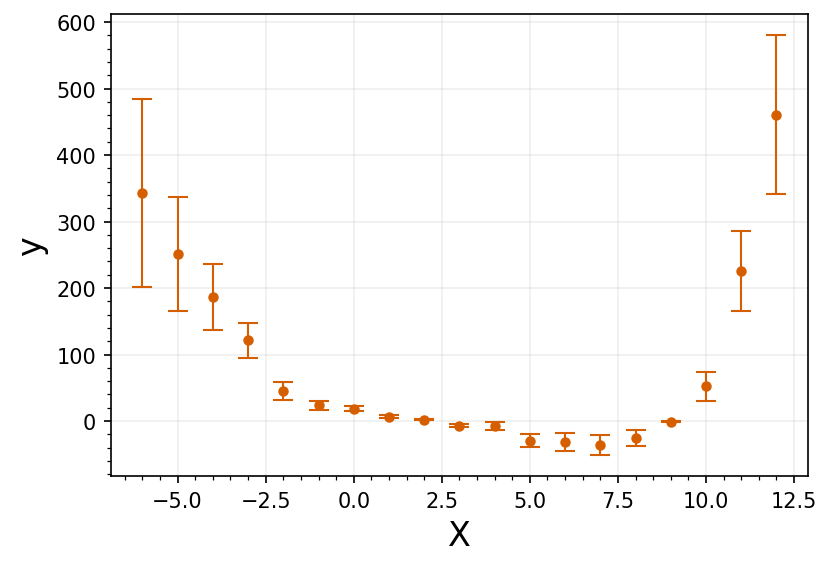

In [27]:
x_values = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

y_measured = [343.39452514, 251.31914561, 186.7806368, 121.30027965, 45.23336652, 23.49470302, 18.46581766, 6.58329486, 1.98522328, -
              6.74799454, -7.55489379, -29.55544088, -31.32898172, -36.27525348, -25.23860169, -1.09156819, 52.32898397, 225.38126087, 460.67437131]

y_err = [141.312, 86.205, 49.632, 26.877, 13.872, 7.197, 4.08, 2.397, 0.672,
         1.923, 5.568, 9.795, 13.488, 14.883, 11.568, 0.483, 22.08, 60.477, 119.712]

#plotting data 
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(x_values, y_measured, yerr = y_err,
            color='#D55E00',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
#ax.xaxis.set_major_locator(MultipleLocator(2.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(20))
#ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

#kinda looks quartic?? - need 5 params

In [28]:
# Define your cost function
ex1_lst_sqrs=LeastSquares(x_values,y_measured,y_err,line_np)

In [29]:
# Define your Minuit object
mobj_quart=Minuit(ex1_lst_sqrs,(5,5,5,5,5))
display(mobj_quart)


,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,
2,x2,5.00,0.05,,,,,
3,x3,5.00,0.05,,,,,
4,x4,5.00,0.05,,,,,


In [30]:
# Run the minimisation
mobj_quart.migrad()
mobj_quart.hesse()



┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 8.74 (chi2/ndof = 0.6)     │              Nfcn = 182              │
│ EDM = 3.17e-08 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.076   │   0.011   │            │            │         │         │       │
│ 1 │ x1   │   -0.90   │   0.14    │            │            │         │         │       │
│ 2 │ x2   │    2.7    │    0.6    │            │            │         │         │       │
│ 3 │ x3   │   -8.8    │    1.5    │            │            │         │         │       │
│ 4 │ x4   │   14.7    │    2.3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4 │
├────┼──────────────────────────────────────────────┤
│ x0 │ 0.000119 -0.00148  0.00337  0.00458  -0.0119 │
│ x1 │ -0.00148   0.0206  -0.0656  -0.0179    0.151 │
│ x2 │  0.00337  -0.0656    0.368    -0.44   -0.167 │
│ x3 │  0.00458  -0.0179    -0.44     2.37    -2.71 │
│ x4 │  -0.0119    0.151   -0.167    -2.71     5.24 │
└────┴──────────────────────────────────────────────┘

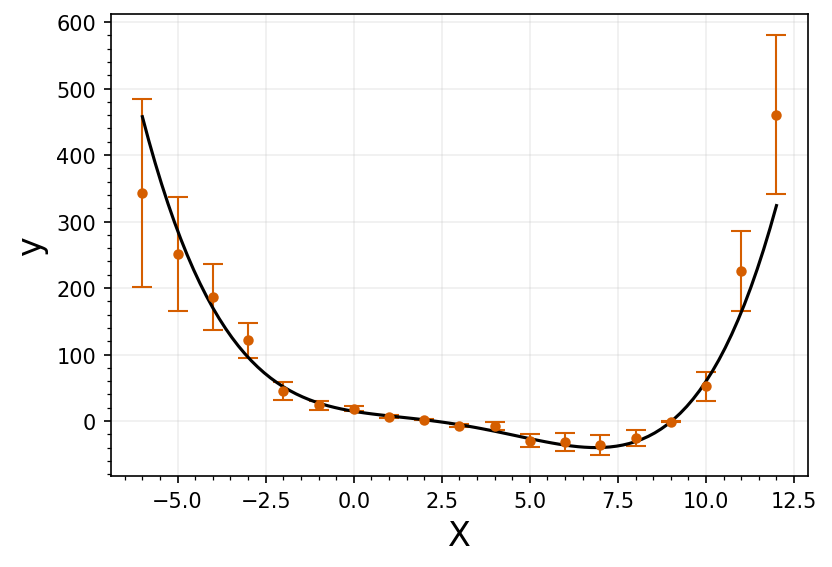

In [31]:
# Plot data and fit
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(x_values, y_measured, yerr = y_err,
            color='#D55E00',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
ax.plot(np.linspace(min(x_values),max(x_values),100),line_np(np.linspace(min(x_values),max(x_values),100),[*mobj_quart.values]),color='black')
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
#ax.xaxis.set_major_locator(MultipleLocator(2.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(20))
#ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

<div style="background-color:#C2F5DD">
    
End of Exercise 1.

## Advanced parameter methods

### Setting limits on parameters

When we are fitting for parameters, we may want to set limits on possible values as our parameter may be limited to a certain range either mathematically or physically. For example, if the function includes $\sqrt{a}$, then $a$ must be non-negative, or if our parameter is an energy then we know it must be positive. 

We can set limits on our parameters using `Minuit.limits` and slicing by the name of the parameter we want to set limits on:

In [32]:
# Create a fresh version of our Minuit object for a simple linear fit
mobj = Minuit(least_squares_obj, m = 3, c = 3)

mobj.limits['m'] = (0,None) # set limit on m to be minimum of 0, no maximum
mobj.limits['c'] = (-float("infinity"), 10) # set maximum value of c as 10, no minimum
mobj.limits['m'] = (0,10) # set limit on m to be minium of 0, maximum of 10
mobj.limits['m'] = (None, None)

We can also set multiple limits at once by passing a sequence of limits:

In [33]:
mobj.limits = [(0, None), (0,10)]
display(mobj.params)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,3.00,0.03,,,0,,
1,c,3.00,0.03,,,0,10,


We can see the limits for each parameter in this listing. 

### Fixing and releasing parameters

We can also fix parameters during the optimisation, so they are not optimised and instead kept at a fixed value. For example, we may have a guess for a parameter value and want to find the optimal values for other parameters for that fixed value. 

You might also have a complex function with many parameters, where a few parameters cause large variations in the function but the rest cause much smaller variations. By first fixing the less important parameters, you can more quickly optimise the most important parameters, and then release the fixed parameters to complete the optimisation. 

We can fix an individual parameter using `Minuit.fixed[<name>] = True`. For example, we can fix $m$ in our straight line example:

In [34]:
# Create a fresh version of our Minuit object for a simple linear fit
mobj = Minuit(least_squares_obj, m = 3, c = 3)

mobj.fixed['m'] = True
display(mobj.params)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,3.00,0.03,,,,,yes
1,c,3.00,0.03,,,,,


If we now run `migrad`, only $c$ with be varied:

In [35]:
mobj.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 453.3 (chi2/ndof = 45.3)   │              Nfcn = 11               │
│ EDM = 4.34e-16 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   3.00    │   0.03    │            │            │         │         │  yes  │
│ 1 │ c    │   0.957   │   0.030   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        m        c │
├───┼───────────────────┤
│ m │        0        0 │
│ c │        0 0.000909 │
└───┴───────────────────┘

We can now release $m$ and instead fix $c$, and run the optimisation again:

In [36]:
mobj.fixed['m'] = False
mobj.fixed['c'] = True
mobj.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 325.1 (chi2/ndof = 32.5)   │              Nfcn = 24               │
│ EDM = 3.07e-17 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   2.42    │   0.05    │            │            │         │         │       │
│ 1 │ c    │   0.957   │   0.030   │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────┐
│   │      m      c │
├───┼───────────────┤
│ m │ 0.0026      0 │
│ c │      0      0 │
└───┴───────────────┘

We could keep iterating like this, but it is only really necessary for more complex cases. For now we will release both parameters and rerun the minimisation.

In [37]:
mobj.fixed = False # Can release all parameters at once this way
mobj.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.741 (chi2/ndof = 0.5)    │              Nfcn = 51               │
│ EDM = 5.1e-16 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   0.98    │   0.10    │            │            │         │         │       │
│ 1 │ c    │   1.97    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        m        c │
├───┼───────────────────┤
│ m │  0.00909 -0.00455 │
│ c │ -0.00455  0.00318 │
└───┴───────────────────┘

### Varying starting points for minimisation

It can also be useful to be able to manually change the values of some fixed parameters and fit the others, or to redo a fit from a different starting point. For example, if the cost function has several minima, changing the starting parameter values can be used to help find the other minimum. 

We define a custom cost function below to show this. We will denote our cost function as $\varphi(\theta)$.

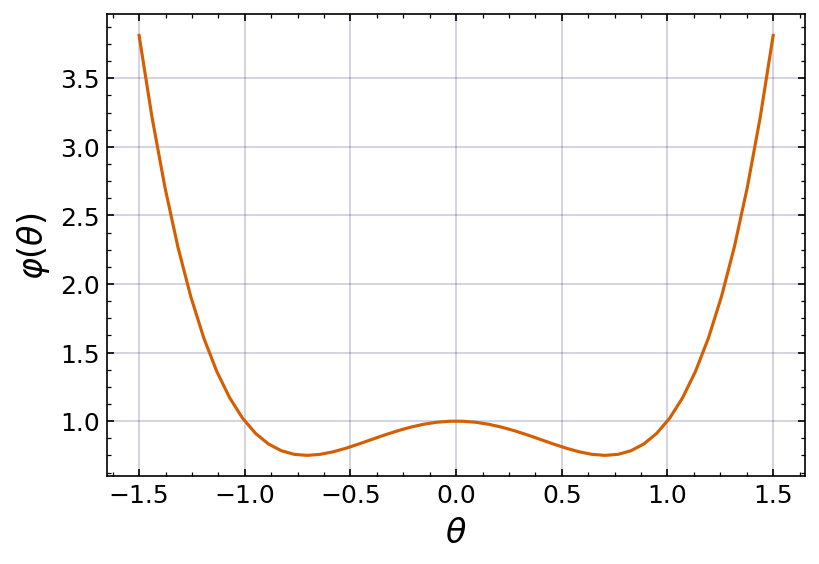

In [38]:
def cost_function_with_two_minima(θ):
    return θ**4 - θ**2 + 1

# We set a parameter called errordef here; we will discuss this later
cost_function_with_two_minima.errordef = Minuit.LEAST_SQUARES

x = np.linspace(-1.5,1.5)
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.plot(x, cost_function_with_two_minima(x),color='#D55E00')
ax.set_xlabel(r'$\theta$',fontsize = 16)
ax.set_ylabel(r'$\varphi(\theta)$',fontsize = 16)
ax.tick_params(direction='in',which='both',top=True,right=True,labelsize = 12)
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_minor_locator(MultipleLocator(0.125))
ax.grid(color='xkcd:dark blue',alpha = 0.2)

In [39]:
# Starting at θ = -0.1 should give us the left minimum
m = Minuit(cost_function_with_two_minima, θ=-0.1)
m.migrad()
print("Starting value θ = -0.1, minimum at θ = {:.2f}".format(m.values['θ']))

# Now changing the starting value to 0.1 gives the right minimum
m.values['θ'] = 0.1
m.migrad()
print("Starting value θ = +0.1, minimum at θ = {:.2f}".format(m.values['θ']))

Starting value θ = -0.1, minimum at θ = -0.71
Starting value θ = +0.1, minimum at θ = 0.71


## Investigating the fit status

As seen before, calling `Minuit.migrad()` runs the actual minimization with the Migrad algorithm. Migrad essentially tries a Newton-step and if that does not produce a smaller function value, it tries a line search along the direction of the gradient. So far so ordinary. The clever bits in Migrad are how various pathological cases are handled.

Let’s look again at the output of `Minuit.migrad()`.

In [40]:
# Again set up a fresh Minuit object using our original simple linear fit example 
mobj = Minuit(least_squares_obj, m=5, c=5)
mobj.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.741 (chi2/ndof = 0.5)    │              Nfcn = 34               │
│ EDM = 6.39e-22 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   0.98    │   0.10    │            │            │         │         │       │
│ 1 │ c    │   1.97    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        m        c │
├───┼───────────────────┤
│ m │  0.00909 -0.00455 │
│ c │ -0.00455  0.00318 │
└───┴───────────────────┘

The `Minuit.migrad()` method returns the Minuit instance so that one can chain method calls, the instance also prints the latest state of the minimization in a nice way.

The *first block* in this output is showing information about the function minimum. This is good for a quick check:

All blocks should be green, other colours mean:
* Purple means something bad.
* Yellow is a warning, telling you that you need to be careful.

Let’s see how it looks when the function is bad:

In [41]:
m_bad = Minuit(lambda x: 0, x=1)  # a constant function has no minimum
m_bad.errordef = 1  # avoid the errordef warning
m_bad.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0                          │              Nfcn = 80               │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │     1     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Coming back to our previous good example, the info about the function minimum can be directly accessed with `Minuit.fmin`:

In [42]:
m.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.75                       │              Nfcn = 61               │
│ EDM = 5.71e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [43]:
# print(repr(...)) to see a detailed representation of the data object
print(repr(m.fmin))

<FMin edm=5.707621004714798e-06 edm_goal=0.0002 errordef=1.0 fval=0.7500057211813171 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=61 ngrad=0 reduced_chi2=nan>


The most important one here is `is_valid`. If this is false, the fit does not converge and the result is useless. Since this value is so often looked at, a shortcut is provided with `Minuit.valid`.

If the fit fails, there is usually a numerical or logical issue.

Either:

- The fit function is not analytical everywhere in the parameter space, e.g. it has a discrete step;

or

- The fit function does not have a local minimum, e.g. the minimum may be at infinity or the extremum may be a saddle point or maximum.

Indicators for this are `is_above_max_edm=True`, `hesse_failed=True`, `has_posdef_covar=False`, or `has_made_posdef_covar=True`.

Possible problems are:


* Migrad reached the call limit before the convergence so that `has_reached_call_limit=True`. The used number of function calls is `nfcn`, and the call limit can be changed with the keyword argument `ncall` in the method `Minuit.migrad()`. Note that `nfcn` can be slightly larger than `ncall`, because Migrad internally only checks this condition after a full iteration, in which several function calls can happen.
* Migrad detects convergence by a small `edm` value, the estimated distance to minimum. This is the difference between the current minimum value of the minimized function and the prediction based on the current local quadratic approximation of the function, which is something that Migrad computes as part of its algorithm. If the fit does not converge, `is_above_max_edm` is true.

If you are interested in parameter uncertainties, you should make sure that:

* `has_covariance`, `has_accurate_covar`, and `has_posdef_covar` are `True`; and
* `has_made_posdef_covar` and `hesse_failed` are `False`.

The *second block* that is printed with `Minuit.migrad()` after information about the fit minimum is the parameter list, which can also be directly accessed with `Minuit.params`.

In [44]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,θ,0.7,0.7,,,,,


`m.params` is a tuple-like container of Param data objects which contain information about the fitted parameters. Important fields are: 
- `number`: parameter index. 
- `name`: parameter name. 
- `value`: value of the parameter at the minimum. 
- `error`: uncertainty estimate for the parameter value.

The accuracy of the uncertainty estimate depends on two factors: the correct mathematical modeling of the fitting problem and the appropriate usage of the `errordef` value in Minuit. By "correct mathematical modelling of the fitting problem", we mean have we chosen an appropriate model to describe our data; we can check how well our model with its fitted parameters describe the data by calculating the reduced chi-squared statistic, as we discussed in Week 3. 



The *last block* that gets printed by running `Minuit.migrad()` shows the covariance matrix, which can also be directly accessed with `Minuit.covariance`. This is useful to check for large correlations which are usually a sign of trouble.

In [45]:
m.covariance

,θ
θ,0.496


<div style="background-color:#C2F5DD">

### Exercise 2

Now that we have introduced how to investigate the fit status, go back to your polynomial fits from before. As you increase the order of the polynomial how does the goodness of fit change? Can you now tell by some goodness of fit measure when the fit shows signs of overfitting?

In [46]:
# Your code here



## Parameter uncertainties, covariances and confidence intervals

You will have seen when we did our simple example, we called `Minuit.hesse` after running the minimisation, to calculate the error accurately. In fact, `iminuit` has two different methods for calculating the uncertainty on parameter estimates, referred to as Hesse and Minos. These two algorithms sound fancy, but they just correspond to the two different methods we saw earlier:

* Hesse numerically calculates the second derivative of the cost function with respect to the parameters to form a matrix then inverts it to find the error matrix (called the Hesse matrix)
* Minos examines the cost function near the minimum to find where the cost function changes by `errordef`, a value specific to the cost function. This can give asymmetric errors.

The two main cost functions we use are the chi-squared and the negative log-likelihood (so it is still a minimisation problem). The `errordef` parameter is equal to 1 for the chi-squared, and 0.5 for the negative log-likelihood, as we would expect from our discussion of fitting earlier. 

In [47]:
least_squares_line = LeastSquares(data_x, data_y, data_yerr, line)
mline = Minuit(least_squares_line, m=5, c=5)
mline.migrad()
mline.fmin


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.741 (chi2/ndof = 0.5)    │              Nfcn = 34               │
│ EDM = 6.39e-22 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [48]:
mline.covariance

,m,c
m,0.00909,-0.00455 (-0.845)
c,-0.00455 (-0.845),0.00318


After we have calculated the covariance matrix by running `Minuit.hesse`, we can also find the correlation matrix:

In [79]:
mline.covariance.correlation()

,x0,x1
x0,1,-0.845
x1,-0.845,1


Correlation is in generally not necessarily bad, but if you can redefine the parameters of the fit function it is generally good to choose parameters which are not strongly correlated.



In general, it is best to use `hesse` by default to calculate parameter uncertainties and we will aim to stick with this for the remainder of the course.

It is also possible to draw confidence regions easily using `iminuit`; for example, we can draw a matrix of contours for the $1\sigma$ confidence interval for all parameters:

In [49]:
import matplotlib.pyplot as plt
mline.draw_mnmatrix()

AttributeError: 'Minuit' object has no attribute 'draw_mnmatrix'

The top-left to bottom-right diagonal plots show the 1D profiles around the minimum of each parameter, while the other plots show the 2D contour in the two parameters. 

We can also draw countours at specified confidence levels, such as the levels corresponding to 1, 2 and 3 $\sigma$ in the Gaussian case, using `Minuit.draw_mncontour`:



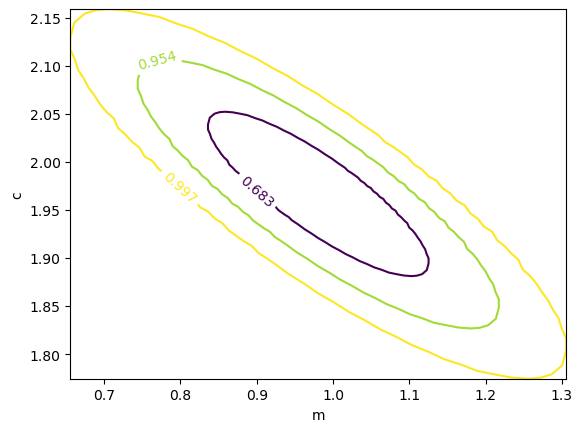

In [51]:
mline.draw_mncontour("m","c",cl=(0.683,0.954,0.997))

We can draw the 1D profiles using `Minuit.draw_profile`:

(array([0.78999355, 0.79384593, 0.7976983 , 0.80155068, 0.80540305,
        0.80925543, 0.8131078 , 0.81696017, 0.82081255, 0.82466492,
        0.8285173 , 0.83236967, 0.83622204, 0.84007442, 0.84392679,
        0.84777917, 0.85163154, 0.85548391, 0.85933629, 0.86318866,
        0.86704104, 0.87089341, 0.87474578, 0.87859816, 0.88245053,
        0.88630291, 0.89015528, 0.89400766, 0.89786003, 0.9017124 ,
        0.90556478, 0.90941715, 0.91326953, 0.9171219 , 0.92097427,
        0.92482665, 0.92867902, 0.9325314 , 0.93638377, 0.94023614,
        0.94408852, 0.94794089, 0.95179327, 0.95564564, 0.95949802,
        0.96335039, 0.96720276, 0.97105514, 0.97490751, 0.97875989,
        0.98261226, 0.98646463, 0.99031701, 0.99416938, 0.99802176,
        1.00187413, 1.0057265 , 1.00957888, 1.01343125, 1.01728363,
        1.021136  , 1.02498837, 1.02884075, 1.03269312, 1.0365455 ,
        1.04039787, 1.04425025, 1.04810262, 1.05195499, 1.05580737,
        1.05965974, 1.06351212, 1.06736449, 1.07

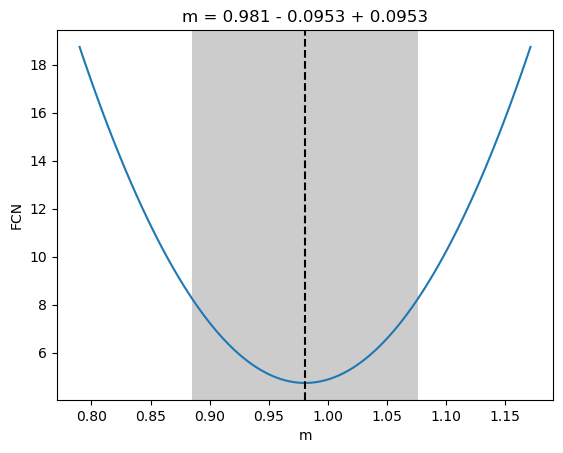

In [52]:
mline.draw_profile("m")

If you want to get the profiles or contours to plot yourself (to make it easier to improve formatting etc), you can use `Minuit.mnprofile` and `Minuit.mncontour` respectively:

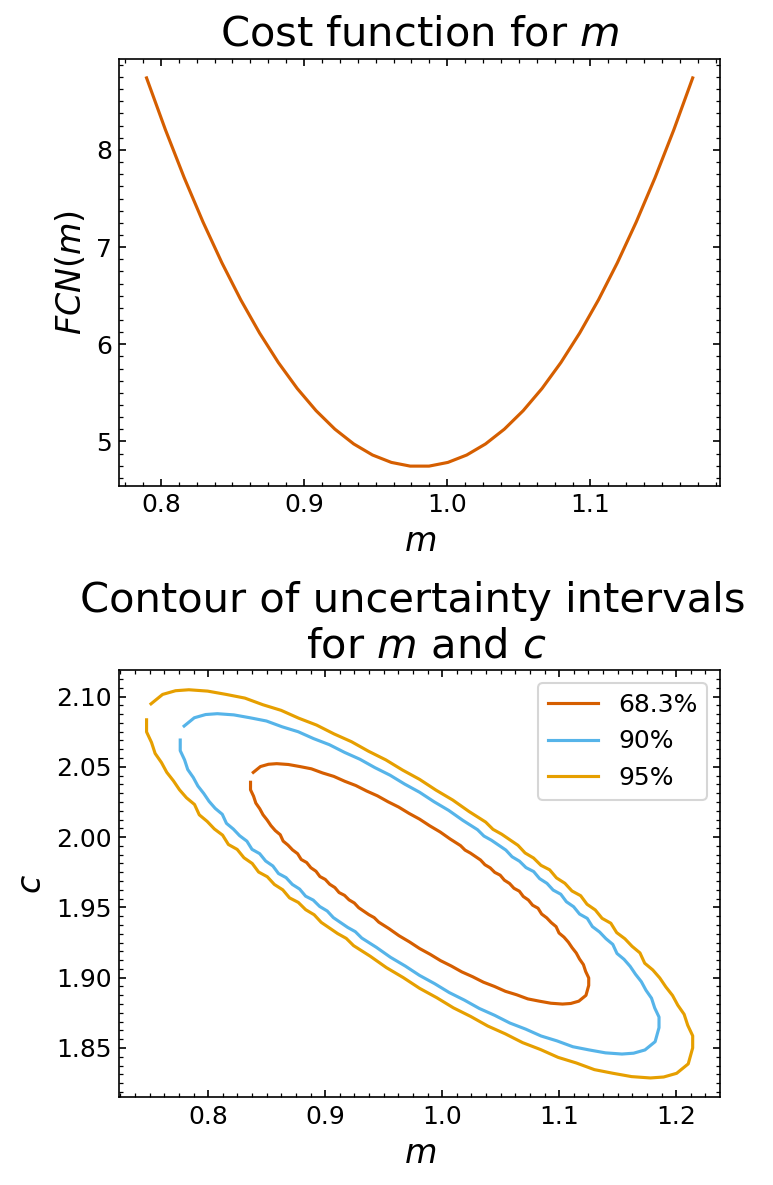

In [53]:
m_h, Lm_h, _ = mline.mnprofile("m")

pts_1 = mline.mncontour("m","c",cl=0.683, size = 100)
pts_2 = mline.mncontour("m","c",cl=0.9,size = 100)
pts_3 = mline.mncontour("m","c",cl=0.95,size = 100)
fig, ax = plt.subplots(2,1,figsize = (5,8),dpi = 150)
ax[0].plot(m_h,Lm_h,color='#D55E00')
ax[0].set_xlabel('$m$', fontsize = 16)
ax[0].set_ylabel(r'$FCN(m)$',fontsize = 16)
ax[0].tick_params(direction='in',top=True,right=True,which='both',labelsize = 12)
ax[0].xaxis.set_minor_locator(MultipleLocator(0.0125))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.125))
ax[0].set_title('Cost function for $m$',fontsize = 20)

ax[1].plot(pts_1.T[0],pts_1.T[1],color='#D55E00',label = '68.3%')
ax[1].plot(pts_2.T[0],pts_2.T[1],color='#56B4E9',label = '90%')
ax[1].plot(pts_3.T[0],pts_3.T[1],color='#E69F00',label = '95%')
ax[1].set_xlabel('$m$',fontsize = 16)
ax[1].set_ylabel('$c$',fontsize = 16)
ax[1].tick_params(which='both',direction='in',top = True, right = True,labelsize = 12)
ax[1].xaxis.set_minor_locator(MultipleLocator(0.0125))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.025/4))
ax[1].legend(loc='upper right',fontsize = 12)
ax[1].set_title('Contour of uncertainty intervals \n for $m$ and $c$',fontsize = 20)

fig.tight_layout()

## Maximum-likelihood fits using `iminuit`

So far, we have looked at simple fits using `LeastSquares`, which is the `iminuit` implementation of the chi-squared parameter estimation method. In practise, many applications instead use maximum-likelihood estimation, which is also implemented in several ways in `iminuit`. We will discuss both unbinned and binned maximum-likelihood fitting using `iminuit`. These differ as follows:

* Unbinned fits apply directly to the raw data sample. The easiest to use, but can become slow when the sample size is large.
* Binned fits are applied to binned data, which means you must appropriately bin your sample. The binning has to be fine enough to retain all the essential information. These are in general much faster than unbinned fits. 

We will discuss how we can do both of these using `iminuit` in turn. We will demonstrate both methods using the same dataset which is a standard example from high-energy physics, the fit of a peak over a smooth background. We will assume a constant background.

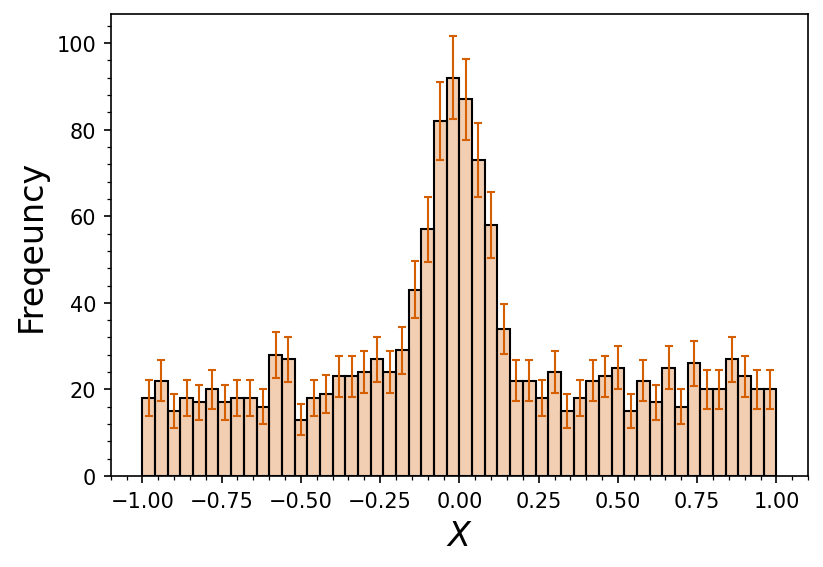

In [54]:
from scipy.stats import norm, uniform
from matplotlib.colors import to_rgba
from matplotlib.ticker import MultipleLocator

xrange = -1, 1
rng = np.random.default_rng(1)

x_data = rng.normal(0, 0.1, size = 400)
x_data = np.append(x_data, rng.uniform(*xrange, size = 1000))

n, xe = np.histogram(x_data, bins = 50, range = xrange)
x_bin_centre = 0.5*(xe[1:]+xe[:-1])
dx = np.diff(xe)

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.bar(x_bin_centre, n, yerr = n**0.5, width = dx,fc=to_rgba('#D55E00',0.3),edgecolor='black',error_kw={'ecolor':'#D55E00','capsize':2,'elinewidth':1,'capthick':1})
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Freqeuncy',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))


### Unbinned maximum-likelihood fits

Unbinned fits are ideal when the data sample isn't too large or very high dimensional. There is not need to worry about appropriate binning of the data, but these can be very inefficient for large samples and can even become numerically unstable. 

The unbinned maximum-likelihood cost function is simply log-likelihood we have previously discussed, multiplied by -1 to go from a maximisation problem to a minimisation problem as this is easier for a computer to handle. 

To perform an unbinned fit, you must provide the (vectorized) PDF of the model i.e. a numpy function or a scipy function. The PDF must also be normalised. 

We will consider an example of a Gaussian peak over a constant background. The corresponding model PDF is the weighted sum of the normal and uniform PDFs. We will only consider $X$ values between 0 and 1, so the uniform component is parameter-free. The parameters of the model are therefore $\mu$ and $\sigma$ of the normal distribution, and $z$, the weighting factor. We can write the total PDF as

\begin{equation*}
f(X; z, \mu, \sigma) = zf_{\text{normal}}(X; \mu, \sigma) + (1 - z)f_{\text{uniform}}(X)
\end{equation*}
where $f_\text{normal}(X; \mu, \sigma)$ and $f_\text{uniform}(X)$ denote the normal and uniform PDFs respectively.

We need to set limits on our parameters to prevent this problem from becoming mathematically undefined. In this case, we want our signal to be within the range $-1 \lt X \lt 1$, and so we require that

\begin{align*}
0 \lt &z \lt 1 \\
-1 \lt &\mu \lt 1 \\
&\sigma \gt 0
\end{align*}

Now we have everything, we can try the fit:

In [55]:
from iminuit.cost import UnbinnedNLL

def model_pdf(x, z, mu, sigma):
    return (z*norm.pdf(x, mu, sigma) + (1-z)*uniform.pdf(x, xrange[0], xrange[1]-xrange[0]))

c = UnbinnedNLL(x_data, model_pdf) # only need to pass the samples we have

m = Minuit(c, z = 0.4, mu = 0, sigma = 0.2) # arbitrary starting parameters
m.limits['z'] = (0,1) # Set limit on z
m.limits['mu'] = (-1, 1) # Set limit on mu
m.limits['sigma'] = (0, None) # Set lower limit on sigma

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1504                       │              Nfcn = 83               │
│ EDM = 3.42e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.275   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000298 -3.66e-06  3.73e-05 │
│    mu │ -3.66e-06  3.79e-05 -2.32e-06 │
│ sigma │  3.73e-05 -2.32e-06  3.22e-05 │
└───────┴───────────────────────────────┘

We can then visualise the result: 

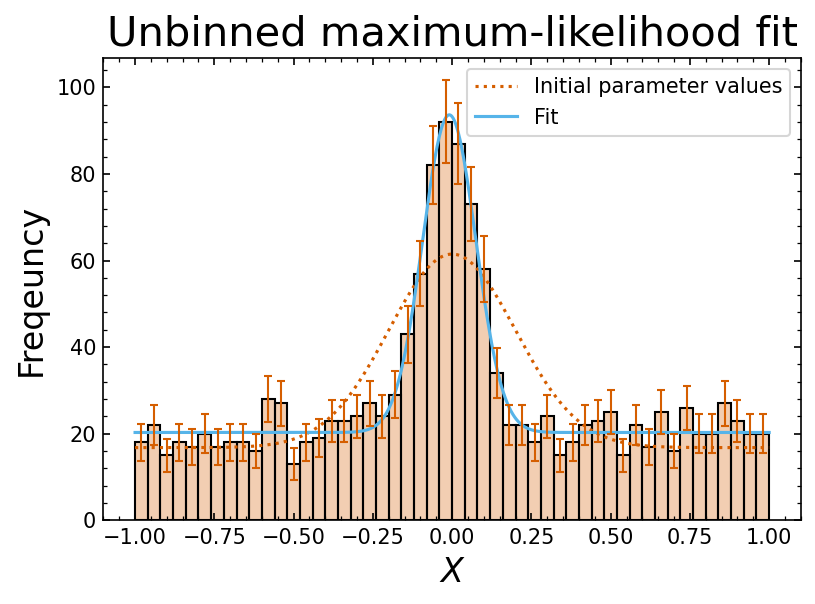

In [57]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi = 150)
ax.bar(x_bin_centre, n, yerr = n**0.5, width = dx,fc=to_rgba('#D55E00',0.3),edgecolor='black',error_kw={'ecolor':'#D55E00','capsize':2,'elinewidth':1,'capthick':1})
#ax.errorbar(x_bin_centre, n, n**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
xm = np.linspace(xe[0],xe[-1],1000)
ax.plot(xm, model_pdf(xm, *[p.value for p in m.init_params])*len(x_data)*dx[0], ls = ':', label='Initial parameter values',color='#D55E00',zorder = 1)
ax.plot(xm, model_pdf(xm, *m.values)*len(x_data)*dx[0], label='Fit',color='#56B4E9',zorder = 1)
ax.legend(loc='upper right')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Freqeuncy',fontsize = 16)
ax.set_title('Unbinned maximum-likelihood fit',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.tick_params(direction='in',which='both',top=True,right=True)


### Binned maximum-likelihood fits

When we have large data samples, binned fits are more computationally efficient and numerically stable. However, you have to choose an appropriate binning, which is non-unique. 

For our example, we have a reasonably large sample (1400 events) and 50 bins is sufficiently fine to retain all information without having too few counts per bin. The maximum likelihood method applied to binned data gives correct results even if bins have no entries, so a binning that is very fine is not a problem and only increases computational cost. 

The cost functions for binned fits that are implemented in Minuit assumes that the bin counts are independently Poisson distributed about some unkown expected value per bin. This is correct for ordinary histograms. 

For a given PDF $f(X; \boldsymbol{\theta})$ with parameters $\boldsymbol{\theta}$, we can write the expected count $\lambda_i$ in a given bin with boundaries $a_i$ and $b_i$ as

\begin{equation*}
\lambda_i = \int_a^bf(X;\boldsymbol{\theta}) dX
\end{equation*}

The cost function for a binned maximum-likelihood fit is the sum of the logarithms of the Poisson probability for the count in each bin, as a function of the expected counts $\lambda_i$. This is again multiplied by -1 to go from a maximisation problem to a minimisation problem. However, instead of supplying a PDF we must provide a CDF in this case. We can approximate the CDF as bin-width multiplied by the PDF evaluated at the bin center if it is difficult to calculate, but this is only an approximation. Using an exact CDF is better.

Now we know what we need, we can define the CDF and run the fit:



In [58]:
from iminuit.cost import BinnedNLL

def model_cdf(xe, z, mu, sigma):
    return (z * norm.cdf(xe, mu, sigma) +
            (1-z) * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = BinnedNLL(n, xe, model_cdf)

m = Minuit(c, z = 0.4, mu = 0, sigma = 0.2)

m.limits['z'] = (0,1)
m.limits['mu'] = (-1,1)
m.limits['sigma'] = (0, None)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 29.74 (chi2/ndof = 0.6)    │              Nfcn = 82               │
│ EDM = 1.88e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.274   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000302 -4.83e-06  4.05e-05 │
│    mu │ -4.83e-06   3.9e-05 -3.26e-06 │
│ sigma │  4.05e-05 -3.26e-06  3.49e-05 │
└───────┴───────────────────────────────┘

The parameter values and uncertainty estimates are not identical to the unbinned fit, but they are very close. In practical terms, our results are equivalent. This shows that the binning we have chosen is good enough to retail the essential information in the data. 

We can then plot the result:

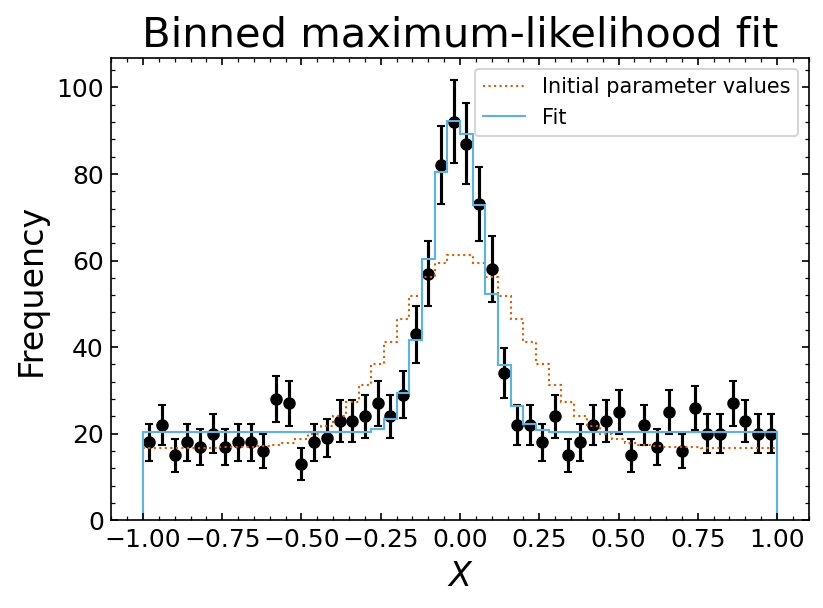

In [59]:
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.errorbar(x_bin_centre, n, n**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
ax.stairs(np.diff(model_cdf(xe, *[p.value for p in m.init_params]))*len(x_data), xe, ls=':',label='Initial parameter values',zorder = 1,color='#D55E00')
ax.stairs(np.diff(model_cdf(xe, *m.values))*len(x_data), xe, label='Fit',zorder = 1,color='#56B4E9')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.set_title('Binned maximum-likelihood fit',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.legend(loc='upper right')
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

### Extended unbinned and binned maximum-likelihood fits

Sometimes, rather than just finding the shape parameters of some underlying probability distributions, we want to also find the integral of the probability distribution. This is particularly common in particle physics where we are trying to estimate physical observables, like the cross section of an interaction. 

For the unbinned case, the model has to return not only the probability density (as before) but also the integral of the density, which corresponds to the total number of counts. For the model we have used so far, this is equivalent to replacing the $z$ term before the normal distriubtion with $n_{\text{sig}}$, the number of signal events, and the $(1-z)$ term before the uniform distribution with $n_{\text{bkg}}$, the number of background events.

For the binned case, we still only need to return the CDF, but we still must make the parameter update as before. In both cases, we are fitting one extra parameter. 

We can run these fits using the cost functions `ExtendedUnbinnedNLL` and `ExtendedBinnedNLL` from `iminuit.cost`. 

### Temporary masking for fitting

When we have a complex data set with one or multiple peak(s) and a background, it can be useful to fit in several stages. It is common to start by **masking** the signal region, so we can fit only the background region. This means we can hide some region of our data, e.g. around where we expect our signal, so we can just fit the background. After we have successfully fit the background, we can then keep the background parameters fixed and fit the signal parameters of the whole distribution.

This is easy to do in `iminuit`, using the `mask` attribute of cost functions.

We can demonstrate this for a binned fit below, where now instead of fitting the fraction of signal and background $z$ we fit for the total number of signal and background events, $n_{\text{sig}}$ and $n_{\text{bkg}}$ respectively. This kind of fit can be referred to as an **extended binned maximum-likelihood fit**, and is useful when we care about the total number of events as well as the shape of the probability distributions. Extended maximum-likelihood fits are non-examinable and will not be discussed further, but are useful as an example for masking. 

In [61]:
from iminuit.cost import ExtendedBinnedNLL

def model_density_cdf(x, nsig, nbkg, mu, sigma):
    return (nsig*norm.cdf(x, mu, sigma) + nbkg*uniform.cdf(x, xrange[0], xrange[1]-xrange[0]))

c = ExtendedBinnedNLL(n, xe, model_density_cdf)

m = Minuit(c, nsig = 300, nbkg = 1500, mu = 0, sigma = 0.2)

m.limits['mu'] = (-1,1)
m.limits['nsig','nbkg','sigma'] = (0, None)
m.fixed['mu','sigma','nsig'] = True # Fix mu, sigma, and the total number of signal events

# The mask is just an array of boolean values, true at each X value to be included 
x_mask_array =(x_bin_centre < -0.5) | (0.5 < x_bin_centre)
c.mask = x_mask_array # Mask the signal between -0.5 and 0.5

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.28 (chi2/ndof = 0.8)    │              Nfcn = 20               │
│ EDM = 2.39e-10 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    300    │     3     │            │            │    0    │         │  yes  │
│ 1 │ nbkg  │  1.00e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ mu    │    0.0    │    0.1    │            │            │   -1    │    1    │  yes  │
│ 3 │ sigma │   0.200   │   0.002   │            │            │    0    │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────┐
│       │    nsig    nbkg      mu   sigma │
├───────┼─────────────────────────────────┤
│  nsig │       0       0       0       0 │
│  nbkg │       0 2.1e+03       0       0 │
│    mu │       0       0       0       0 │
│ sigma │       0       0       0       0 │
└───────┴─────────────────────────────────┘

We can now plot the background result we have fitted:



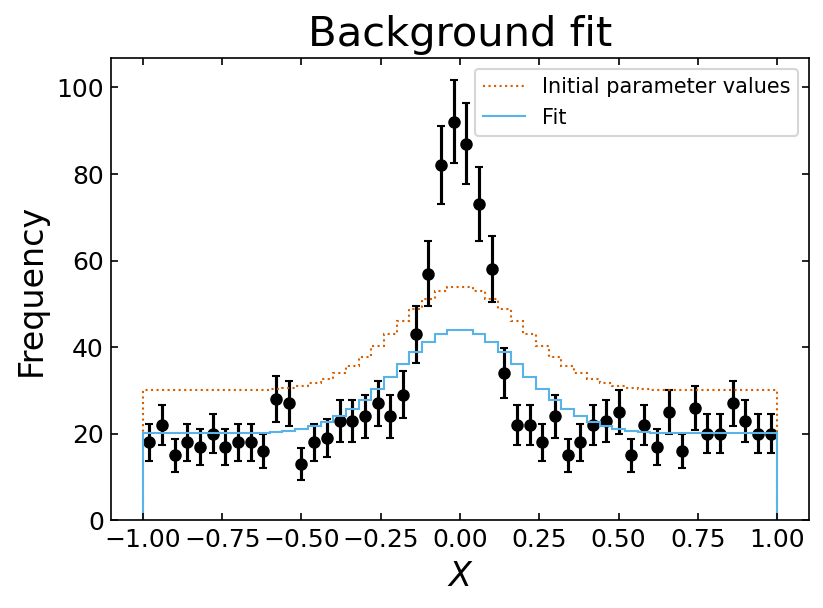

In [62]:
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.errorbar(x_bin_centre, n, n**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
ax.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe, ls=':',label='Initial parameter values',zorder = 1,color='#D55E00')
ax.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label='Fit',zorder = 1,color='#56B4E9')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.set_title('Background fit',fontsize = 20)
# ax.xaxis.set_minor_locator(MultipleLocator(0.05))
# ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.legend(loc='upper right')
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

We can see the background leve looks about right, but obviously our signal region has not been fitted. We can now fix the background, remove the mask, and fit only the signal parameter. 

In [63]:
c.mask = None # Remove the mask of the signal region
m.fixed = False # Release all parameters
m.fixed['nbkg'] = True # Fix the background amplitude

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 29.86 (chi2/ndof = 0.6)    │              Nfcn = 91               │
│ EDM = 8.78e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    386    │    25     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.00e3   │  0.05e3   │            │            │    0    │         │  yes  │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig      nbkg        mu     sigma │
├───────┼─────────────────────────────────────────┤
│  nsig │       625         0  -0.00529    0.0439 │
│  nbkg │         0         0         0         0 │
│    mu │  -0.00529         0   3.9e-05 -3.02e-06 │
│ sigma │    0.0439         0 -3.02e-06  3.29e-05 │
└───────┴─────────────────────────────────────────┘

Finally, we release all of the parameters and run the fit again to get correct estimates of the uncertainty. 

In [64]:
m.fixed = None
m.migrad()


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 29.74 (chi2/ndof = 0.6)    │              Nfcn = 158              │
│ EDM = 5.84e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    383    │    26     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig      nbkg        mu     sigma │
├───────┼─────────────────────────────────────────┤
│  nsig │       696      -313  -0.00676    0.0567 │
│  nbkg │      -313  1.33e+03   0.00676   -0.0567 │
│    mu │  -0.00676   0.00676  3.89e-05 -3.26e-06 │
│ sigma │    0.0567   -0.0567 -3.26e-06  3.49e-05 │
└───────┴─────────────────────────────────────────┘

We can now plot the full result:


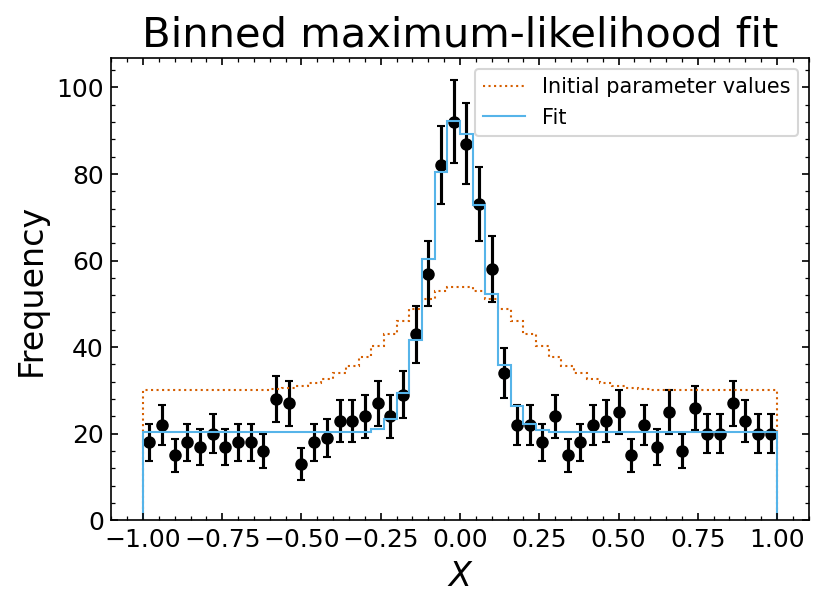

In [65]:
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.errorbar(x_bin_centre, n, n**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
ax.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe, ls=':',label='Initial parameter values',zorder = 1,color='#D55E00')
ax.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label='Fit',zorder = 1,color='#56B4E9')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.set_title('Binned maximum-likelihood fit',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.legend(loc='upper right')
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

As we can see, this is exactly the same as when we did the fit all in one go. This is because we have used a simple example, but in general this can be very helpful to fit lots of histograms without having to adjust each fit manually.


## Summary

In this section, you have seen how to do fitting using `iminuit`, including:

* The basics of fitting
* Details of the Minuit object
* How to set limits on parameters and fix values during fitting
* How to calculate and plot confidence intervals on fitted parameters
* Binned and unbinned maximum-likelihood fits

While we have covered many things here, this is by no means a comprehensive summary of `iminuit`. If you want to learn more, look at the [documentation](https://iminuit.readthedocs.io/en/stable/). The tutorials are in general very useful for understanding different approaches/techniques for fitting.

The following section covers the exercises for you to work through this week.

<hr style="border:2px solid gray">
<a id='exercises'></a>

# Exercises [^](#outline)

For the exercises this week, you will work through a problem that is very close to some real data. 

<div style="background-color:#C2F5DD">

### Exercise 3

The data you will use for this problem is saved in a file named "signal". The code cell below will load this data in using `pickle`. Plot a histogram of the raw data sample from this file, making sure to consider the following points:

* Clear axis labels
* Good choice of colours
* Good plot resolution


In [66]:
import pickle as pk

with open('signal','rb') as infile:
    data = pk.load(infile)

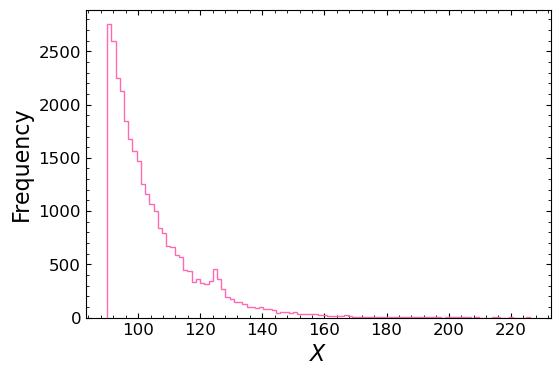

In [78]:
# Your plotting code here
fig,ax=plt.subplots(1,1,figsize=(6,4))
counts,edges,patches=ax.hist(data,bins=100,histtype='step',color='hotpink')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(4))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

<div style="background-color:#C2F5DD">

### Exercise 4

Now that you have loaded the data, we will start by trying to fit a polynomial function using the `LeastSquares` cost function. We will use `np.polyval` to define our model. Try using different polynomial orders up to 10. Remember you can extract the value of the cost function from your Minuit object, using `m.fmin`, which will also tell you your reduced chi-squared value. What is the best reduced chi-squared you can get?

In [147]:
# Preprare data
data_y, bins = np.histogram(data, bins = 150)
data_x = 0.5*(bins[1:]+bins[:-1]) # x value is centre of each bin

# Assume Poisson random variable for each bin count, so error is sqrt(count). EFS:- WHY?
# Cost function doesn't like any error = 0 so make sure any that would be 0 are instead 0.1
data_yerr = [e if e>0 else 0.1 for e in np.sqrt(data_y)] 
data_y[-1]

1

In [119]:
# Our old friend the n-order polynomial
def line_np(x, par):
    return np.polyval(par, x)

In [122]:
# Define cost function
cost_polyval=LeastSquares(data_x,data_y,data_yerr,line_np)

In [134]:
# Define Minuit object
m_polyval=Minuit(cost_polyval,[5,5,5,5,5,5,5]) 

In [135]:
# Fit Minuit object
m_polyval.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.698e+16 (chi2/ndof = 188676933335931.4)│              Nfcn = 782              │
│ EDM = 6.25e+04 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │16.376900833011e-3│0.000000000002e-3│            │            │         │         │       │
│ 1 │ x1   │-17.4069204478495│0.0000000000005│            │            │         │         │       │
│ 2 │ x2   │7.62087902015842e3│0.00000000000011e3│            │            │         │         │       │
│ 3 │ x3   │-1.756714026854377e6│0.000000000000024e6│            │            │         │         │       │
│ 4 │ x4   │224.511030785393e6│0.000000000005e6│            │            │         │         │       │
│ 5 │ x5   │-15.0547443662696e9│0.0000000000010e9│            │            │         │         │       │
│ 6 │ x6   │412.90691814641e9│0.00000000018e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6 │
├────┼───────────────────────────────────────────────────────────────────────┤
│ x0 │  4.01e-30 -4.83e-28 -7.49e-26 -9.73e-24 -7.19e-22  1.34e-19  8.77e-17 │
│ x1 │ -4.83e-28   2.3e-25 -1.43e-23 -2.13e-21  -2.5e-19 -8.36e-18   7.8e-15 │
│ x2 │ -7.49e-26 -1.43e-23  1.18e-20  -4.6e-19 -7.39e-17 -1.01e-14 -8.98e-13 │
│ x3 │ -9.73e-24 -2.13e-21  -4.6e-19  5.56e-16    -2e-14 -4.02e-12 -7.81e-10 │
│ x4 │ -7.19e-22  -2.5e-19 -7.39e-17    -2e-14  2.42e-11 -1.26e-09    -3e-07 │
│ x5 │  1.34e-19 -8.36e-18 -1.01e-14 -4.02e-12 -1.26e-09  9.46e-07 -9.32e-05 │
│ x6 │  8.77e-17   7.8e-15 -8.98e-13 -7.81e-10    -3e-07 -9.32e-05    0.0309 │
└────┴───────────────────────────────────────────────────────────────────────┘

In [136]:
# Plot result; remember you can call line_np as line_np(x, m.values) to use the fitted values
fig,ax=plt.subplots(1,1,figsize=(6,4))
counts,edges,patches=ax.hist(data,bins=100,histtype='step',color='hotpink',label='Data')
ax.plot(data_x,line_np(data_x,m_polyval.values),label='Fit')
ax.legend()
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(4))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')


Locator attempting to generate 22026967 ticks ([-410976400.0, ..., 1791720200.0]), which exceeds Locator.MAXTICKS (1000).


Error in callback <function _draw_all_if_interactive at 0x0000022E63F77670> (for post_execute):


KeyboardInterrupt: 

Locator attempting to generate 22026967 ticks ([-410976400.0, ..., 1791720200.0]), which exceeds Locator.MAXTICKS (1000).


Error in callback <function flush_figures at 0x0000022E63F95AF0> (for post_execute):


KeyboardInterrupt: 

<div style="background-color:#C2F5DD">

### Exercise 5

Now try fitting the data with an exponential, again with the `LeastSquares` cost function. The function has been defined for you below. Discuss with the person next to you what you think good starting parameter values might be.

In [149]:
def exp(x, a, b, c):
    return a*np.exp(-(x-b)/c)

In [150]:
# Define cost function
c_exp=LeastSquares(data_x,data_y,data_yerr,exp)


In [172]:
# Fit Minuit object
m_exp=Minuit(c_exp,a=1,b=200,c=14)
m_exp.migrad()


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 976.9 (chi2/ndof = 6.6)    │              Nfcn = 88               │
│ EDM = 2.5e-08 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.56    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   195.3   │    1.0    │            │            │         │         │       │
│ 2 │ c    │   12.79   │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │  0.00183   -0.039 0.000394 │
│ b │   -0.039    0.965  0.00931 │
│ c │ 0.000394  0.00931  0.00254 │
└───┴────────────────────────────┘

Text(0, 0.5, 'Frequency')

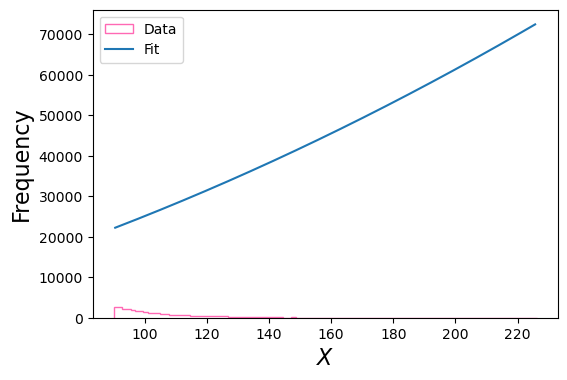

In [174]:
# Plot result
xtest=np.linspace(min(data_x),max(data_x),100)
fig,ax=plt.subplots(1,1,figsize=(6,4))
counts,edges,patches=ax.hist(data,bins=100,histtype='step',color='hotpink',label='Data')
ax.plot(data_x,line_np(data_x,m_exp.values),label='Fit')
#ax.plot(xtest,exp(xtest,1,200,14))
ax.legend()
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
#ax.xaxis.set_minor_locator(MultipleLocator(4))
#ax.yaxis.set_minor_locator(MultipleLocator(100))
#ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')



<div style="background-color:#C2F5DD">

### Exercise 6

Now, we will try a more sophisticated model, composed of an exponential and a Gaussian. First, try fitting all of the data simultaneously. The function has been defined in the code cell below. Make sure to plot your results. 

Take care with your choice of initial parameters, as this will significantly affect your results.

In [ ]:
def exp_plus_gauss(x, A, mu, sigma, B, C, D):
    return B*np.exp(-(x-C)/D) + A*np.exp(-(x - mu)**2/(2*sigma**2))

In [ ]:
# Define cost function



In [ ]:
# Define Minuit object



In [ ]:
# Fit Minuit object



In [ ]:
# Plot result



<div style="background-color:#C2F5DD">

### Exercise 7

Now we will use the same function, but you should mask the signal region $120 \leq X \leq 130$ to fit just the exponential background first. Remember the following steps:

* Fix the signal parameters `A`, `mu`, and `sigma`
* Set physical limits on background parameters `B`, `C`, and `D` (`B` and `D` should be strictly positive)
* Mask the relevant region
* Fit the model
* Fix background parameters and release signal parameters
* Set physical limits on signal parameters (`A` and `sigma` should be positive, `mu` should lie in the range of the data)
* Remove the mask
* Fit the model 
* Finally, release all parameters and fit one final time

Take care with your choice of initial parameters, as this can make a large difference to the result of your fit. Make sure to plot your final result.

In [ ]:
# Define cost function



In [ ]:
# Define Minuit object



In [ ]:
# Fix signal parameters and set limits on background parameters



In [ ]:
# Mask the signal region



In [ ]:
# Fit the model



In [ ]:
# Release the signal parameters, fix background parameters, set limits on signal parameters, remove the mask



In [ ]:
# Fit the model



In [ ]:
# Release all parameters, refit the whole model & calculate error using hesse



In [ ]:
# Plot final result



<div style="background-color:#C2F5DD">

Does the masking approach improve the quality of your fit? What is the value of $\mu$ for your Gaussian signal? Answer in the Markdown cell below.

Your answer here

<div style="background-color:#C2F5DD">

### Exercise 8 

Now repeat fitting the background and signal simultaneously, but this time using a binned maximum-likelihood fit. The code cell below defines a CDF you can use for this purpose. Make sure your binning is fine enough to capture the features of the data. Remember to set physical limits on your parameters, including:

* `mu` and `C`: within the range of the data, i.e. between `x.min()` and `x.max()`
<br>

* `sigma` and `D` as strictly $\gt 0$
<br>

* $0 \leq$ `z` $\leq 1$

Remember to use the `BinnedNLL` cost function.




In [ ]:
from scipy.stats import norm, expon

# expon is an exponentially distributed random variable

def comp_cdf(x, mu, sigma, C, D, z):
    return z*norm.cdf(x, mu, sigma) + (1-z)*expon.cdf(x, C, D)

In [ ]:
# Define your cost function



In [ ]:
# Define your Minuit object & set limits on parameters



In [ ]:
# Fit your function



In [ ]:
# Plot your results



<div style="background-color:#C2F5DD">

### Exercise 9

Finally, repeat the unbinned maximum-likelihood fit with the same masking procedure we used for the `LeastSquares` cost function, but this time using the CDF we have defined and the `BinnedNLL` cost function. Remember the key steps:

* Fix the signal parameters `mu`, and `sigma`
* Set physical limits on background parameters `C`, and `D` 
* Mask the relevant region
* Fit the model
* Fix background parameters and release signal parameters
* Set physical limits on signal parameters 
* Remove the mask
* Fit the model 
* Finally, release all parameters and fit one final time


How does the result from this compare with the unmasked approach? How does it compare with the `LeastSquares` results? What about the uncertainty on the fitted parameters? Write your answers in the Markdown cell after the code cells.


In [ ]:
# Define cost function



In [ ]:
# Define Minuit object



In [ ]:
# Fix signal parameters and set limits on background parameters



In [ ]:
# Mask the signal region



In [ ]:
# Fit the model



In [ ]:
# Release the signal parameters, fix background parameters, set limits on signal parameters, remove the mask



In [ ]:
# Fit the model



In [ ]:
# Release all parameters, refit the whole model & calculate error using hesse


In [ ]:
# Plot final result



Your answer here